## Results needed:

Calibration curve for each detector

the efficiency as a function of energy,

and the absolute efficiency,

intrinsic efficiency,

and geometric factors as functions of angle.

You do not need to show every single spectra you obtained: a wise choice would be to include an example of a single fitted spectra for each detector, and include any other spectra you feel important in an appendix at the end of the report.

You should also include tables containing the fitted parameters and uncertainties in an append

# Step 1:

* Upload data
* Plot counts vs channels - counts in bins

In [1]:
#!pip install lmfit

In [2]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [3]:
def parse_spe_files(filename):
    IS_DATA = False
    headers = {}
    data = []

    current_key = None
    current_value_lines = []

    with open(filename) as file:
        for line in file:
            line = line.strip()

            # detect start of data section
            if line == "$DATA:":
                # save the last header value before switching
                if current_key is not None:
                    headers[current_key] = "\n".join(current_value_lines).strip()
                IS_DATA = True
                continue

            # handle header lines
            if not IS_DATA:
                if line.startswith("$"):
                    # save previous header (if exists)
                    if current_key is not None:
                        headers[current_key] = "\n".join(current_value_lines).strip()
                    
                    # start a new header
                    current_key = line.strip()
                    current_value_lines = []
                else:
                    current_value_lines.append(line)
            else:
                # inside data section
                if line.startswith("0 1023"):
                    continue
                try:
                    counts = float(line.strip())
                    data.append(counts)
                except ValueError:
                    # silently skip non-data lines
                    continue

    # in case file doesn’t end with $DATA:
    if not IS_DATA and current_key is not None:
        headers[current_key] = "\n".join(current_value_lines).strip()

    # build data dictionary
    channels = np.arange(len(data))
    counts = np.array(data)

    return headers, channels, counts

In [4]:
def counts_per_sec(counts, exposure_time):
    counts_per_sec = counts / exposure_time
    return counts_per_sec

In [5]:
def plot_spectra(bkg_file, file):
    headers, channels, counts = parse_spe_files(file)
    bkg_headers, bkg_channels, bkg_counts = parse_spe_files(bkg_file)
    
    meas_bkg = bkg_headers["$MEAS_TIM:"]
    time_bkg = meas_bkg.split(" ")
    bkg_exp_time = int(time_bkg[0])
    
    bkg_counts_per_sec = counts_per_sec(np.array(bkg_counts), bkg_exp_time)
    
    meas_time = headers["$MEAS_TIM:"]
    time = meas_time.split(" ")
    exposure_time = int(time[0])
    
    counts_sec = counts_per_sec(np.array(counts), exposure_time)
    
    counts_minus_bkg = (np.array(counts_sec) - np.array(bkg_counts_per_sec)).flatten()
    
    if "Am" in file:
        title = "$Am_{241}$"
        
    if "co" in file:
        title = "$Co_{60}$"
        
    if "Ba" in file:
        title = "$Ba_{133}$"
        
    if "Cs" in file:
        title = "$Cs_{137}$"
    
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(channels, counts_minus_bkg, label=f"{title} Spectrum")
    ax.set_title(f"{title} Spectrum BGO Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    plt.tight_layout()
    plt.show()
    
    return headers, channels, counts_sec, counts_minus_bkg

In [6]:
BGO_bkg_file = "BGO_Bck_10min.Spe"
BGO_Ba = "BGO_Ba_direct.Spe"

<IPython.core.display.Javascript object>


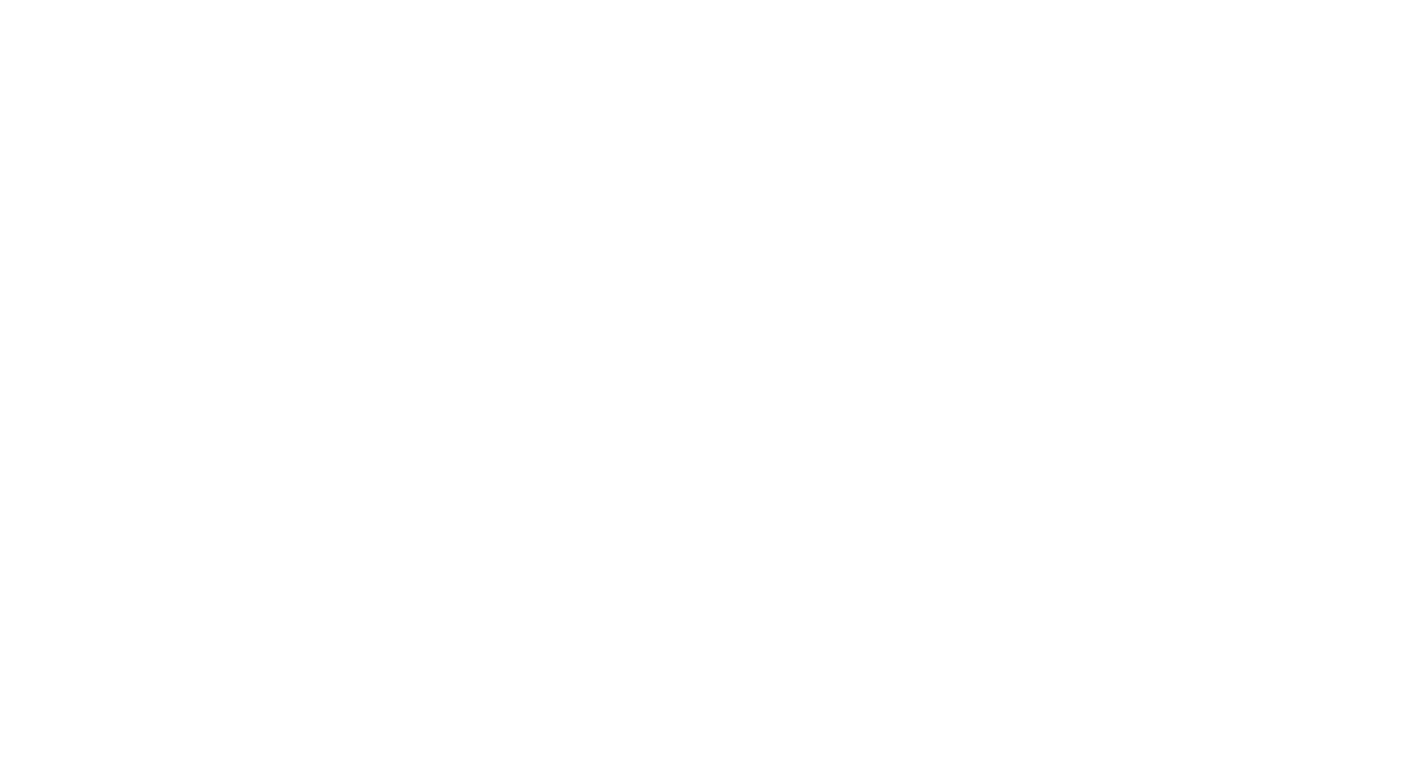

In [7]:
BGO_Ba_headers, BGO_Ba_channels, BGO_Ba_counts_sec, BGO_Ba_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Ba)

In [8]:
BGO_Co = "bgo-co60-000-20cm-u.Spe"

<IPython.core.display.Javascript object>


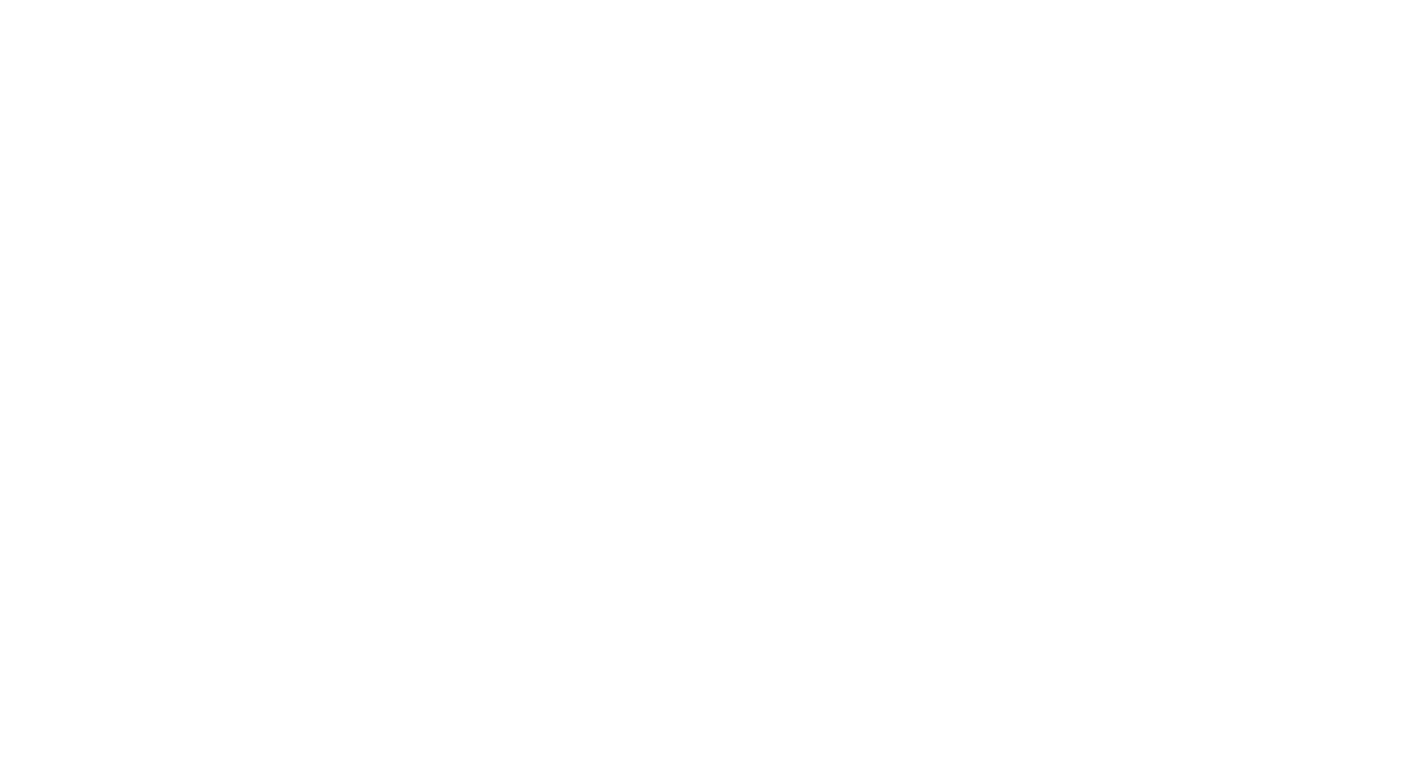

In [9]:
BGO_Co_headers, BGO_Co_channels, BGO_Co_counts_sec, BGO_Co_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Co)

In [10]:
BGO_Am = "BGO_Am_241_direct.Spe"

<IPython.core.display.Javascript object>


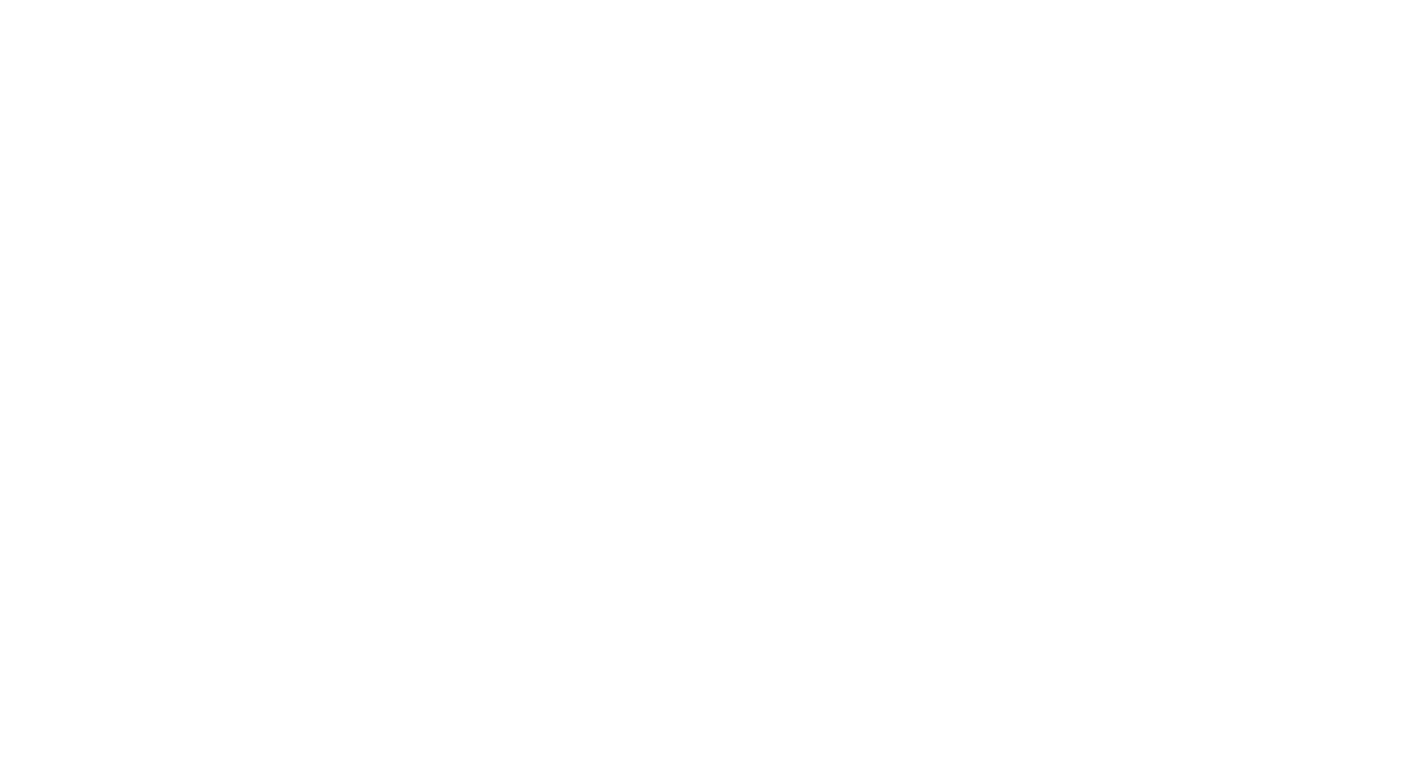

In [11]:
BGO_Am_headers, BGO_Am_channels, BGO_Am_counts_sec, BGO_Am_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Am)

<IPython.core.display.Javascript object>


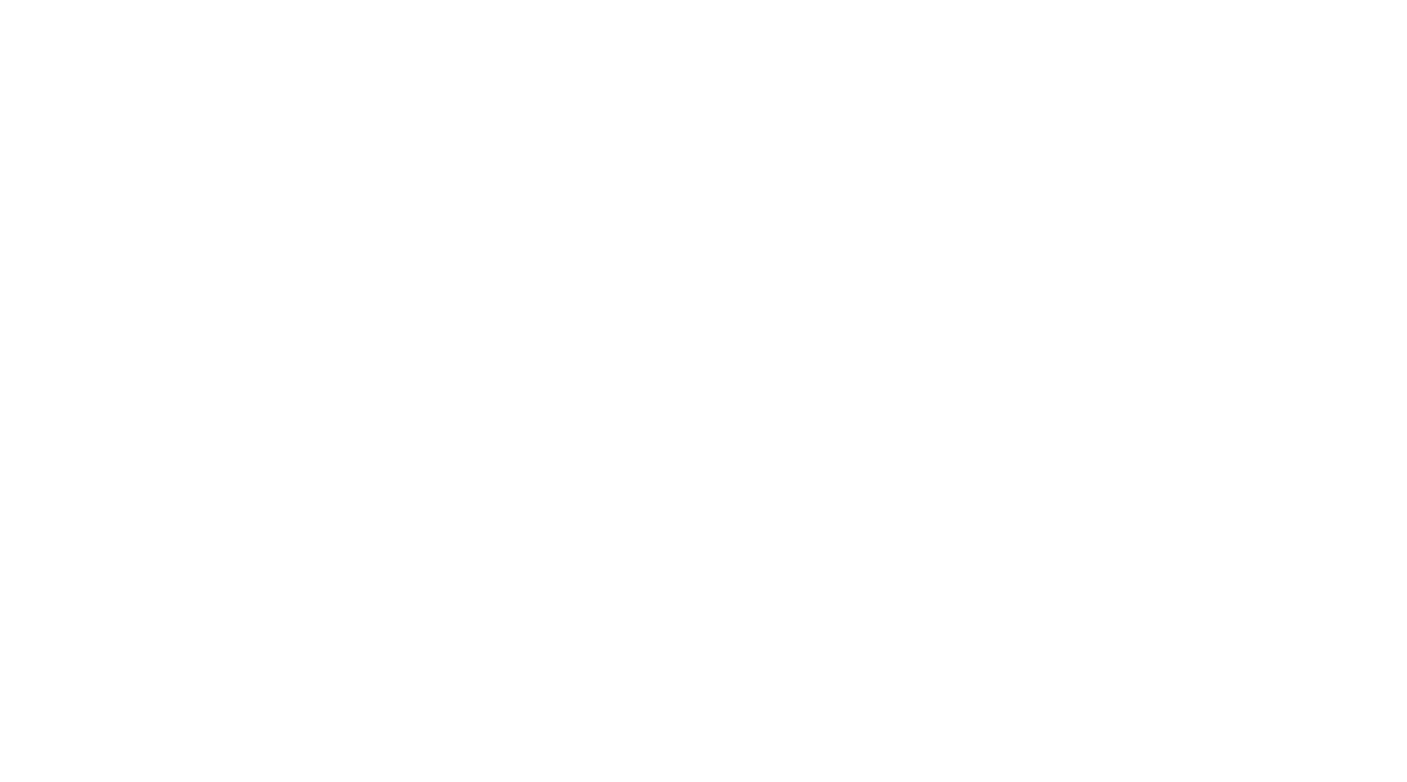

In [12]:
BGO_Cs = "BGO_Cs137_direct.Spe"
BGO_Cs_headers, BGO_Cs_channels, BGO_Cs_counts_sec, BGO_Cs_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Cs)

* Use curve fit to fit Gaussian to peaks
* popt 3 & 4 is an x and y coord of the peak
* Get energy of peak from website
* Assign energy to y value, get channel from x value
* Find energies and channels annd fit linear relationship

In [13]:
from lmfit import Model
from lmfit.models import GaussianModel

* amp = amp
* cen = mu
* wid = sigma

In [14]:
from scipy.signal import find_peaks

In [15]:
Ba_energies = [53.1622, 79.6142, 80.9979]
Am_energies = [59.5409]
Cs_energies = [661.657]
Co_energies = [1173.228, 1332.492]

In [73]:
def fitting_peaks(channels, counts, lower, upper, height, width, title):
    # find peaks
    peaks, _ = find_peaks(counts, height=height, width=width)
    
    # loop through peaks and fit gaussian
    model = GaussianModel()
    
    gauss_peaks = []
    centroids = []
    centroid_error = []
    fwhm = []
    fwhm_error = []
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(channels, counts, "--")
    
    for peak in peaks:
        channel_range = np.arange((peak-lower), (peak+upper))
        
        params = model.guess(counts[channel_range], channels[channel_range])
        
        result = model.fit(counts[channel_range], x=channels[channel_range], params=params)
        
        # add result to arrays
        gauss_peaks.append(result)
        centroids.append(result.params["center"].value)
        centroid_error.append(result.params["center"].stderr)
        fwhm.append(result.params["fwhm"].value)
        fwhm_error.append(result.params["fwhm"].stderr)
        
        ax.plot(channels[channel_range], result.init_fit, "--", label="initial fit peak")
        ax.plot(channels[channel_range], result.best_fit, "-", label="best fit peak")
        
    ax.set_title(f"{title} Fitted Peaks BGO Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    ax.legend()
    plt.show()
        
    return gauss_peaks, centroids, centroid_error, fwhm, fwhm_error

<IPython.core.display.Javascript object>


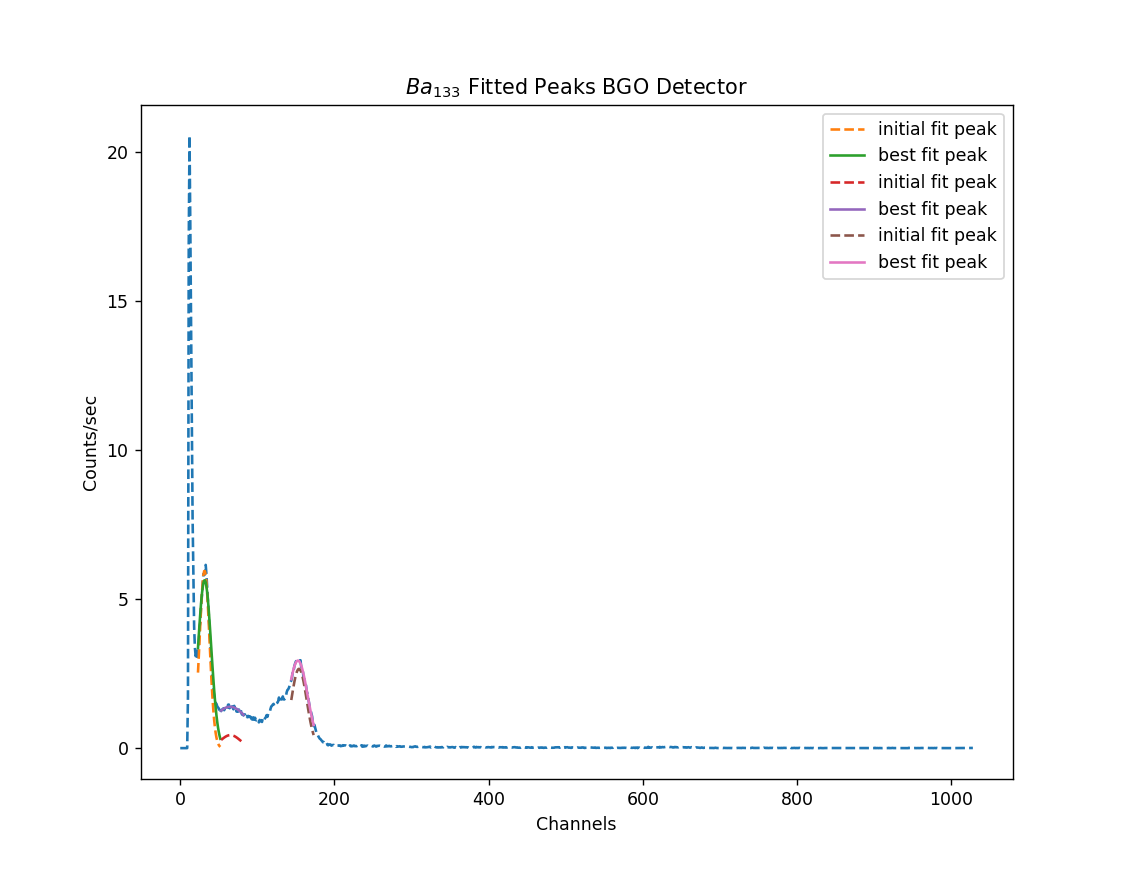

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [74]:
BGO_Ba_peaks, BGO_Ba_centroids, BGO_Ba_error, BGO_Ba_fwhm, BGO_Ba_fwhm_error = fitting_peaks(BGO_Ba_channels, BGO_Ba_counts_sec, 10, 20, 0.5, 5, "$Ba_{133}$")

<IPython.core.display.Javascript object>


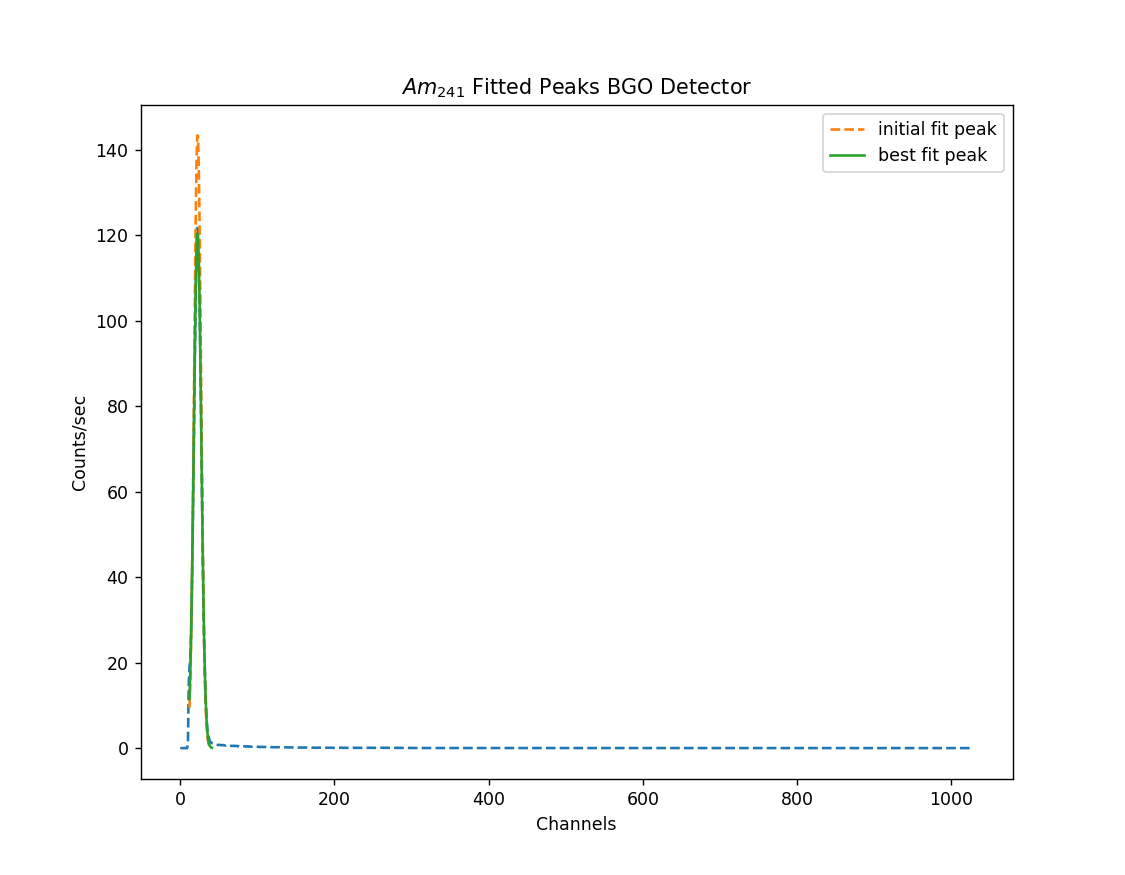

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [75]:
BGO_Am_peaks, BGO_Am_centroids, BGO_Am_error, BGO_Am_fwhm, BGO_Am_fwhm_error = fitting_peaks(BGO_Am_channels, BGO_Am_counts_sec, 10, 20, 20, None, "$Am_{241}$")

<IPython.core.display.Javascript object>


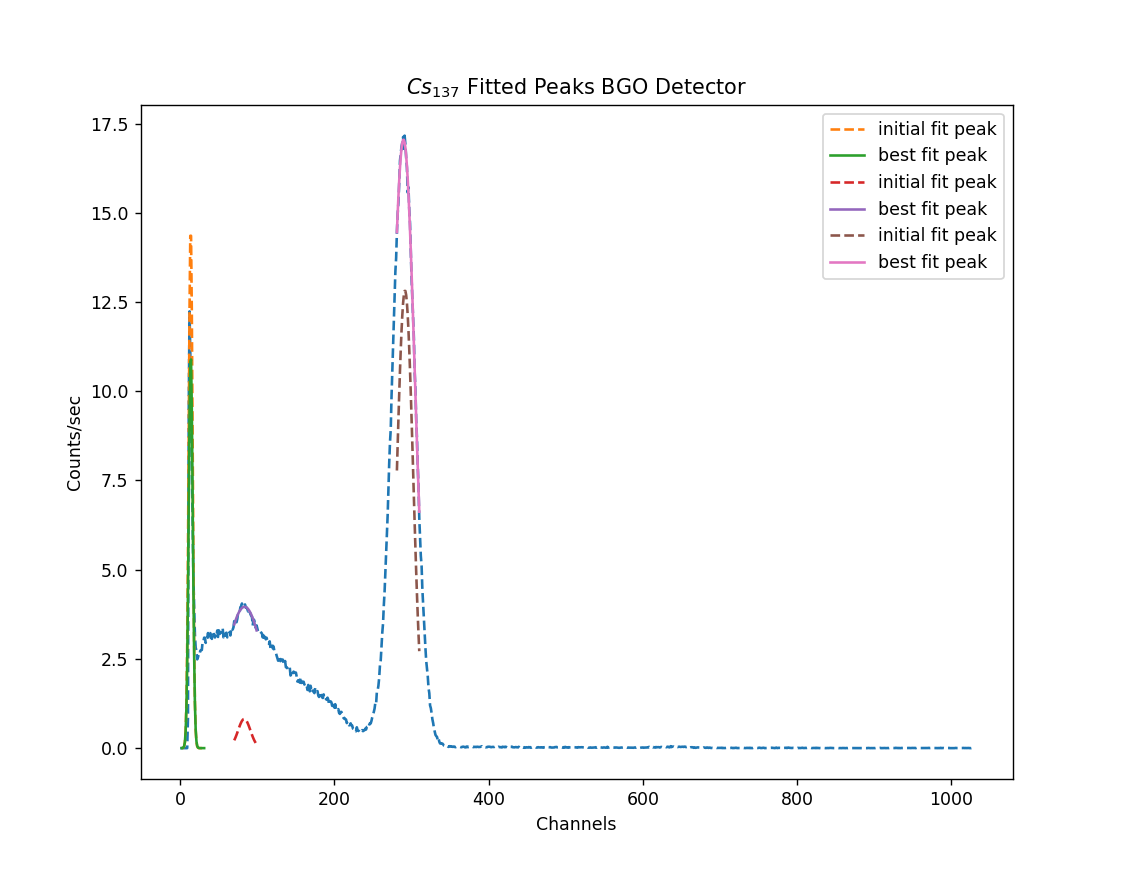

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [76]:
BGO_Cs_peaks, BGO_Cs_centroids, BGO_Cs_error, BGO_fwhm, BGO_fwhm_error = fitting_peaks(BGO_Cs_channels, BGO_Cs_counts_sec, 10, 20, 2.5, 5, "$Cs_{137}$")

<IPython.core.display.Javascript object>


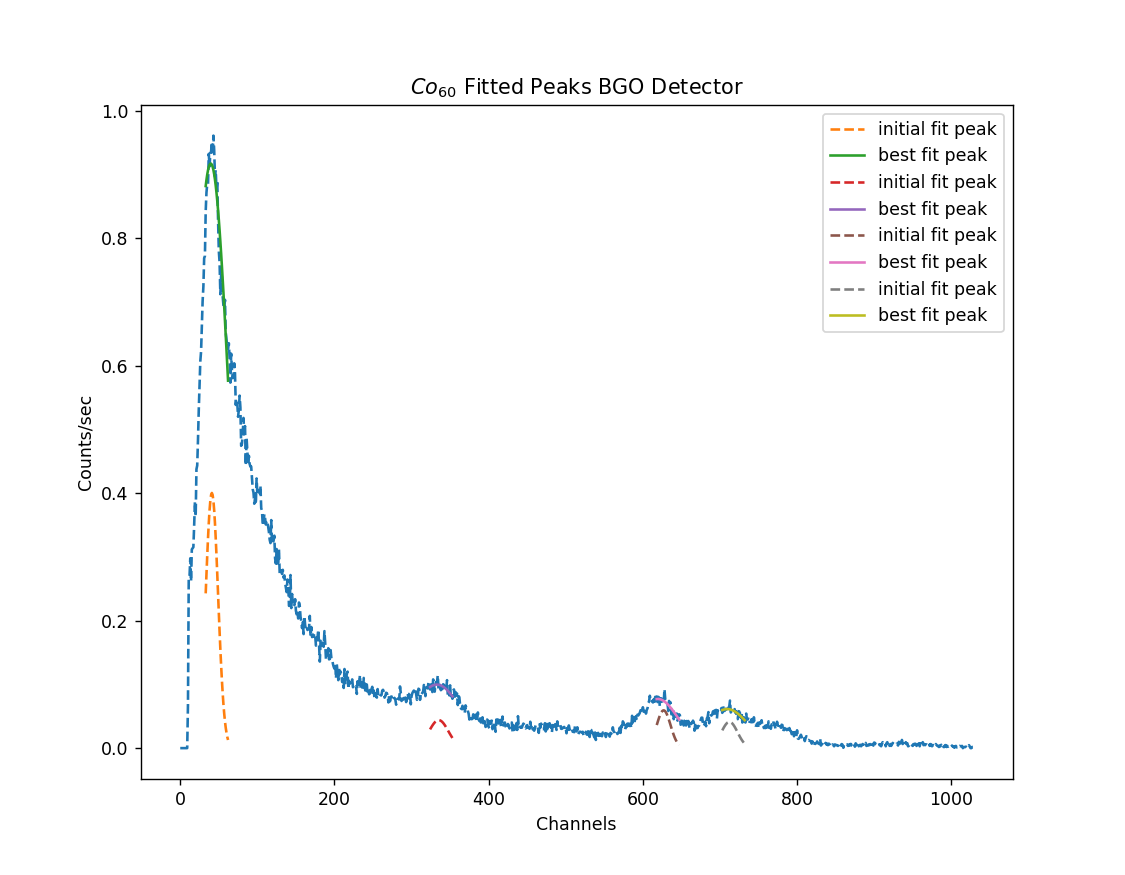

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [77]:
BGO_Co_peaks, BGO_Co_centroids, BGO_Co_error, BGO_Co_fwhm, BGO_Co_fwhm_error = fitting_peaks(BGO_Co_channels, BGO_Co_counts_sec, 10, 20, 0.05, 6, "$Co_{60}$")

In [21]:
BGO_dictionary = {"Barium-133":[BGO_Ba_centroids, BGO_Ba_error, Ba_energies],
                 "Americium-241":[BGO_Am_centroids, BGO_Am_error, Am_energies],
                 "Cobalt-60":[BGO_Co_centroids, BGO_Co_error, Co_energies],
                 "Caesium-137":[BGO_Cs_centroids, BGO_Cs_error, Cs_energies]}

In [22]:
BGO_df = pd.DataFrame(data=BGO_dictionary)
#df.to_csv('BGO_results.csv', index=False)

In [23]:
# %load BGO_results.csv

In [24]:
BGO_channels = BGO_Ba_centroids + BGO_Am_centroids + BGO_Cs_centroids[2:3] + BGO_Co_centroids[2:4]

In [25]:
BGO_energies = Ba_energies + Am_energies + Cs_energies + Co_energies

In [26]:
from lmfit.models import LinearModel
def linear_fit(energies, channels, name):
    Lmodel = LinearModel()
    params = Lmodel.guess(energies, channels)

    result_linear = Lmodel.fit(energies, x = channels, params = params)
    fig, ax = plt.subplots(figsize=(9,5))
    ax.scatter(channels, energies)
    ax.plot(channels, result_linear.best_fit)
    ax.set_title(f"{name} Energies vs Channels")
    ax.set_xlabel(f"{name} Channels")
    ax.set_ylabel(f"{name} Energies")
    
    return result_linear

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


<IPython.core.display.Javascript object>


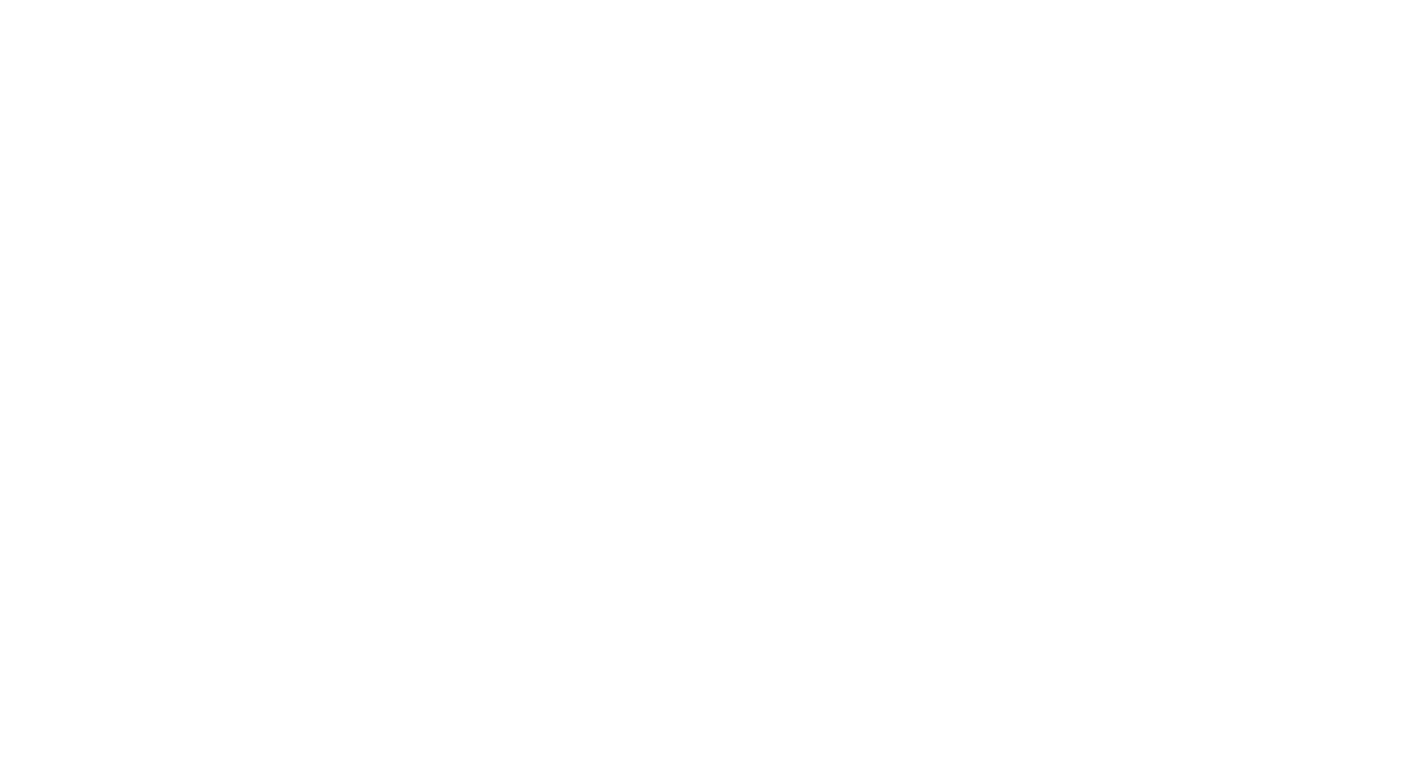

In [27]:
BGO_linear_result = linear_fit(BGO_energies, BGO_channels, "BGO")

In [28]:
from lmfit.models import QuadraticModel

In [29]:
NaI_bkg_file = "NaI_bck_10min.Spe"
NaI_Ba_file = "NaI_Ba_direct.Spe"
NaI_Cs_file = "NaI_Cs_direct.Spe"
NaI_Co_file = "nai-co60-000-10cm-u.Spe"
NaI_Am_file = "NaI_Am_direct.Spe"

<IPython.core.display.Javascript object>


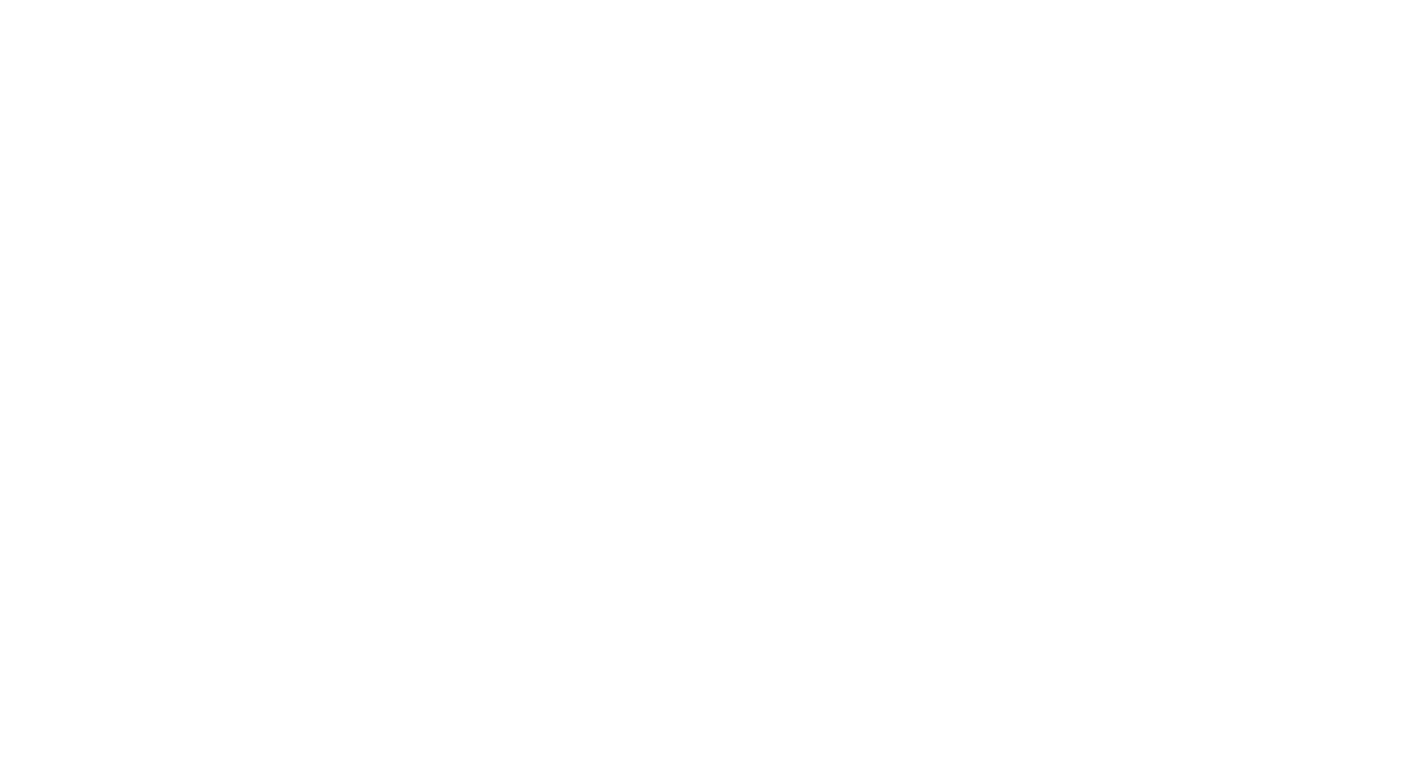

In [30]:
NaI_Ba_headers, NaI_Ba_channels, NaI_Ba_counts, NaI_Ba_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Ba_file)

<IPython.core.display.Javascript object>


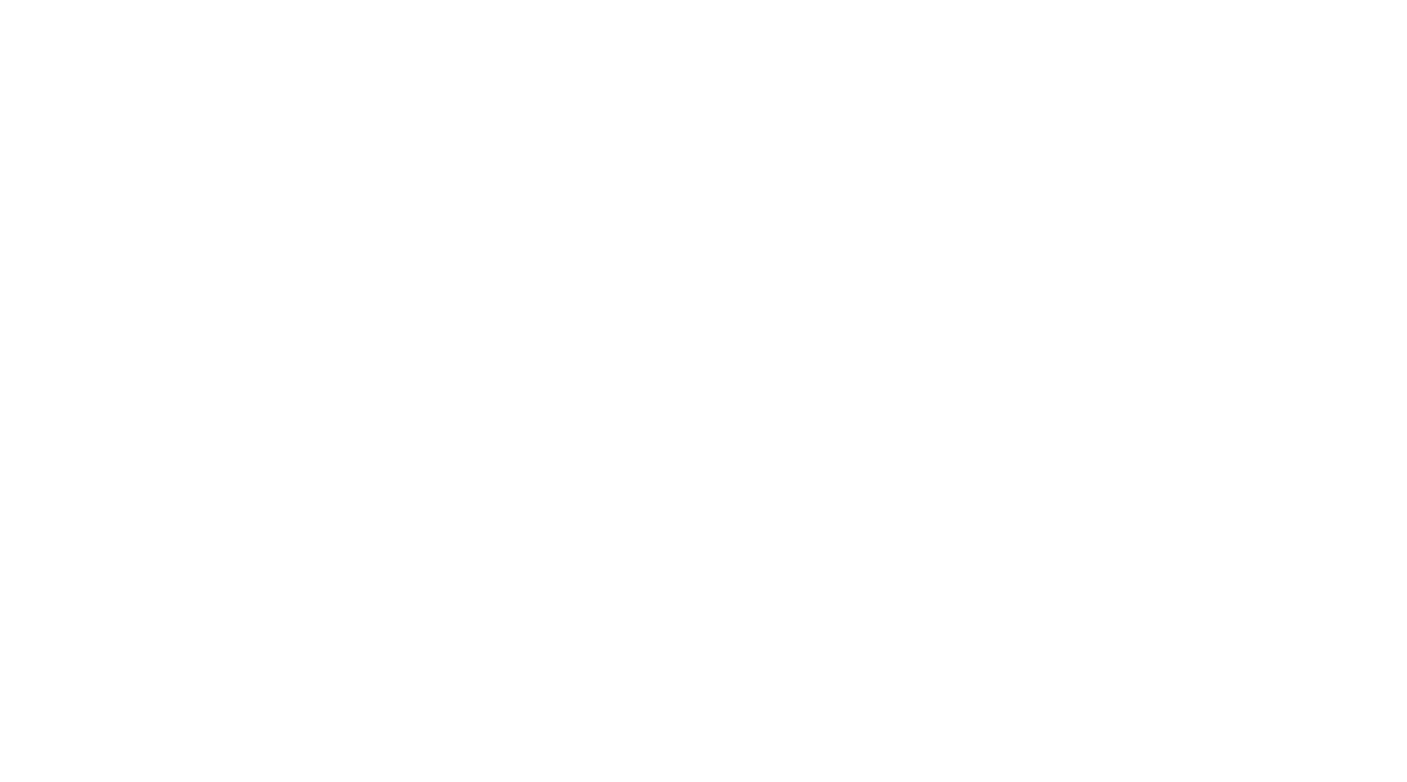

In [31]:
NaI_Am_headers, NaI_Am_channels, NaI_Am_counts, NaI_Am_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Am_file)

<IPython.core.display.Javascript object>


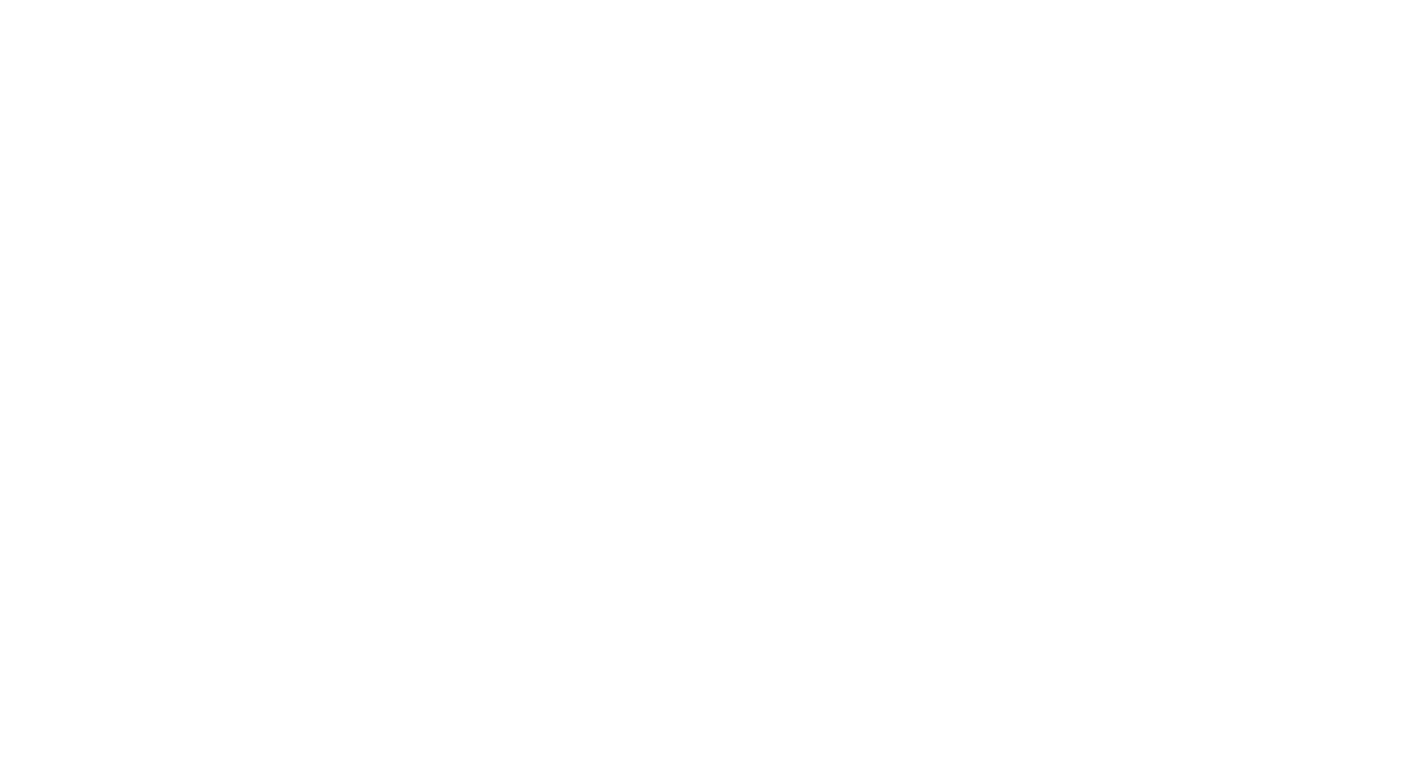

In [32]:
NaI_Cs_headers, NaI_Cs_channels, NaI_Cs_counts, NaI_Cs_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Cs_file)

<IPython.core.display.Javascript object>


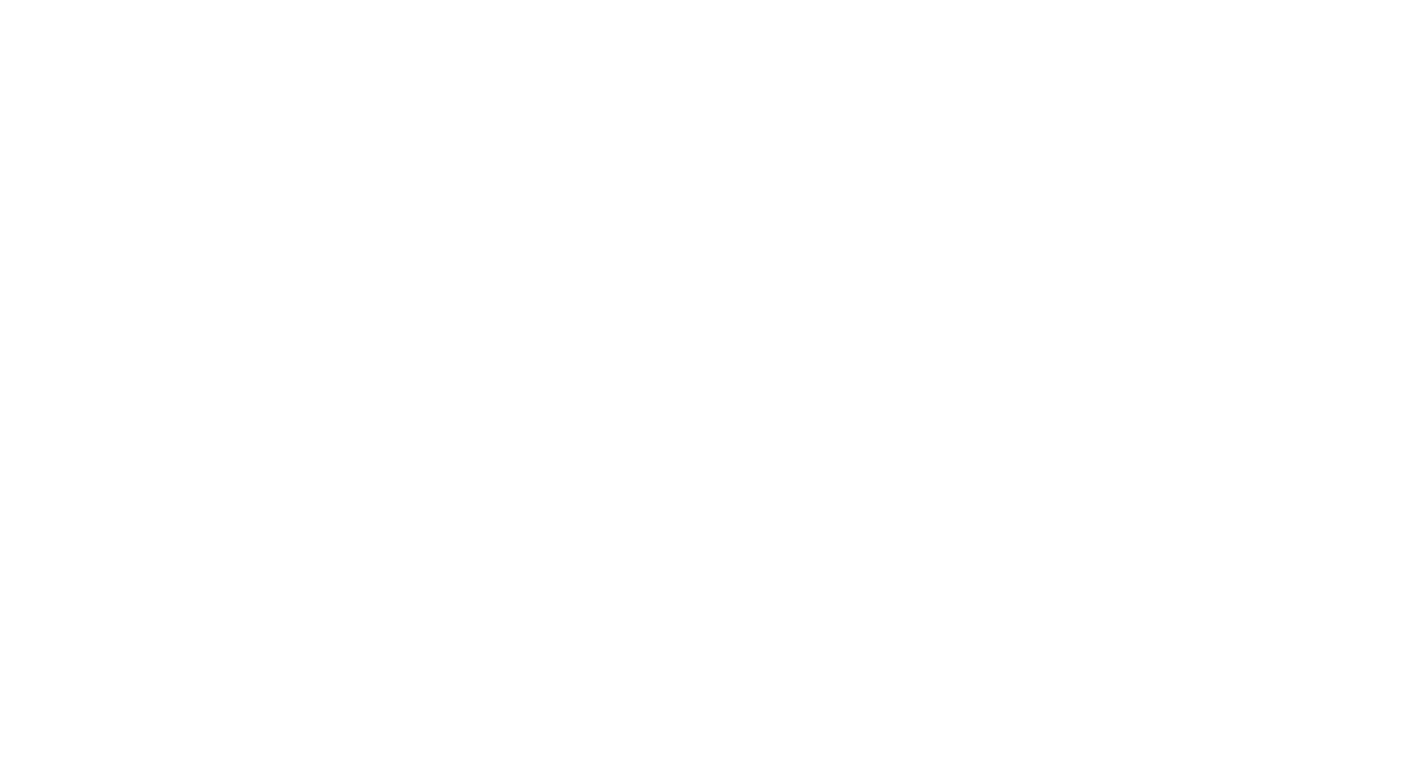

In [33]:
NaI_Co_headers, NaI_Co_channels, NaI_Co_counts, NaI_Co_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Co_file)

<IPython.core.display.Javascript object>


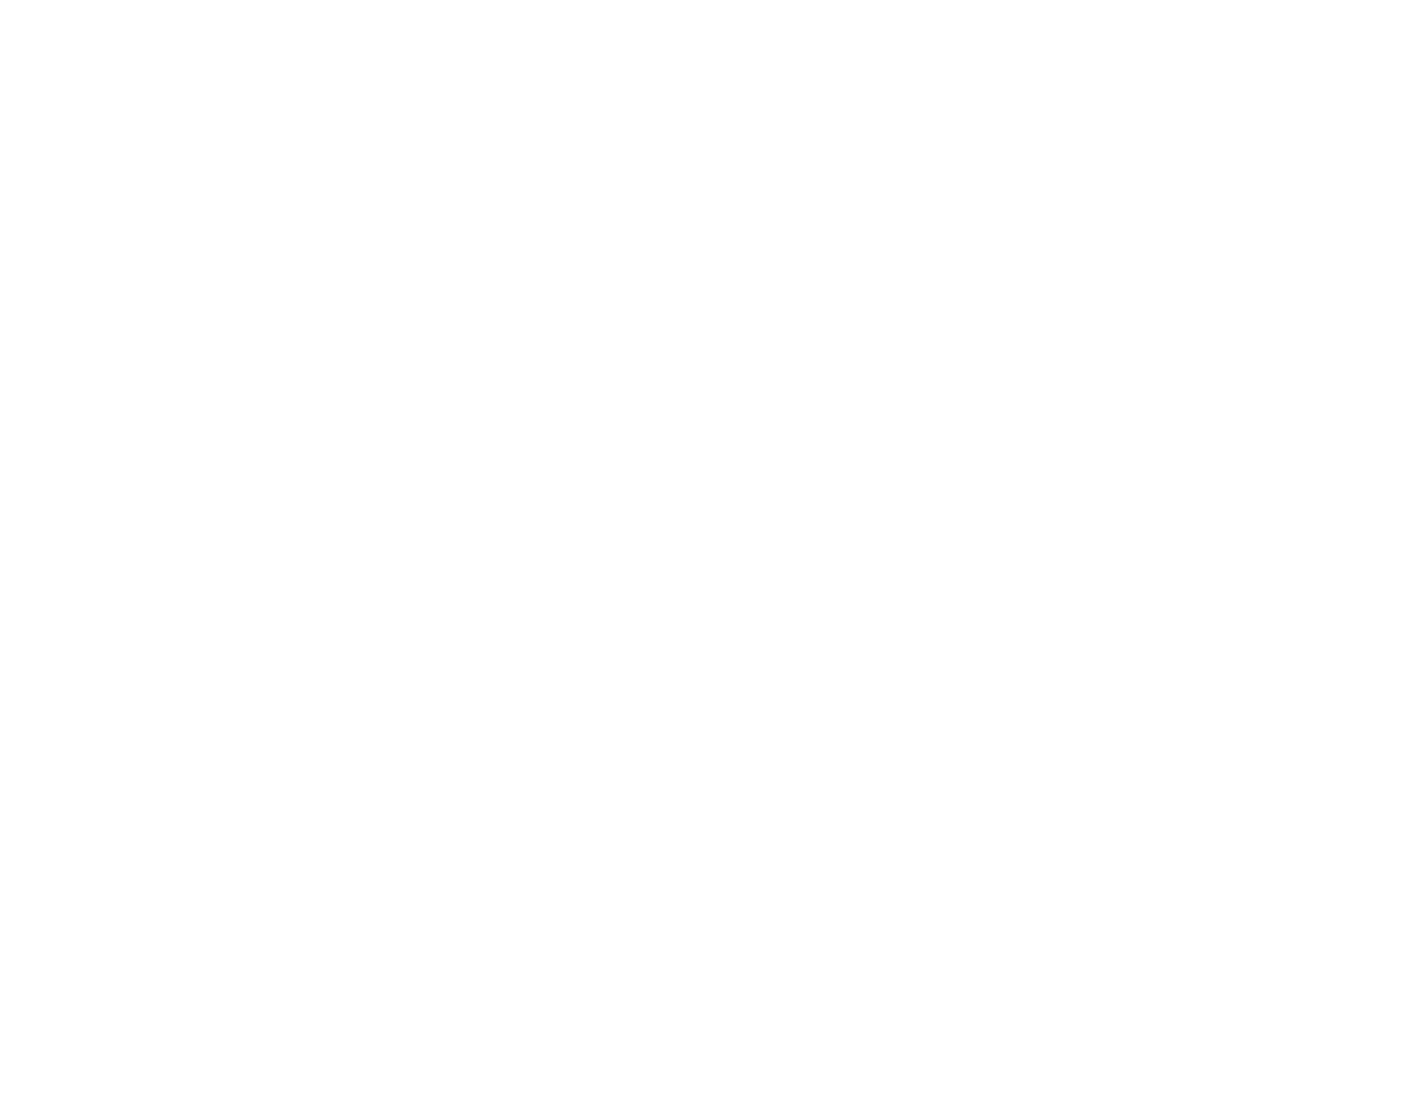

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [34]:
NaI_Ba_peaks, NaI_Ba_centroids, NaI_Ba_error = fitting_peaks(NaI_Ba_channels, NaI_Ba_counts, 10, 20, 0.5, 3, "$Ba_{133}$")

<IPython.core.display.Javascript object>


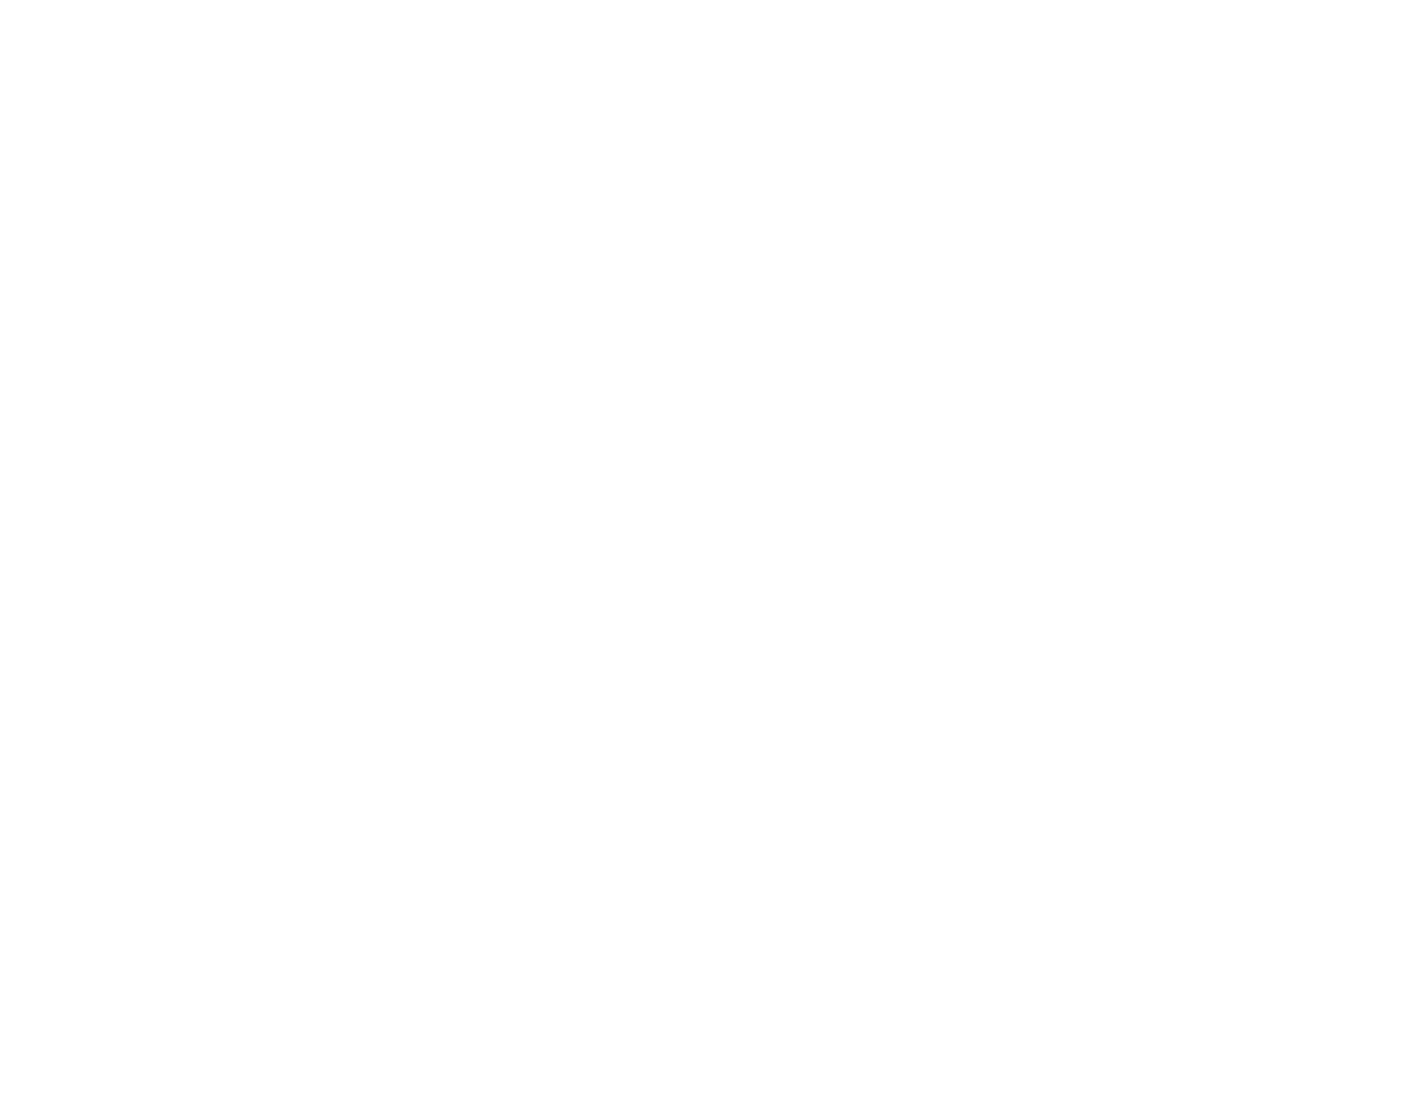

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [35]:
NaI_Am_peaks, NaI_Am_centroids, NaI_Am_error = fitting_peaks(NaI_Am_channels, NaI_Am_counts, 10, 20, 0.5, 3, "$Am_{241}$")

<IPython.core.display.Javascript object>


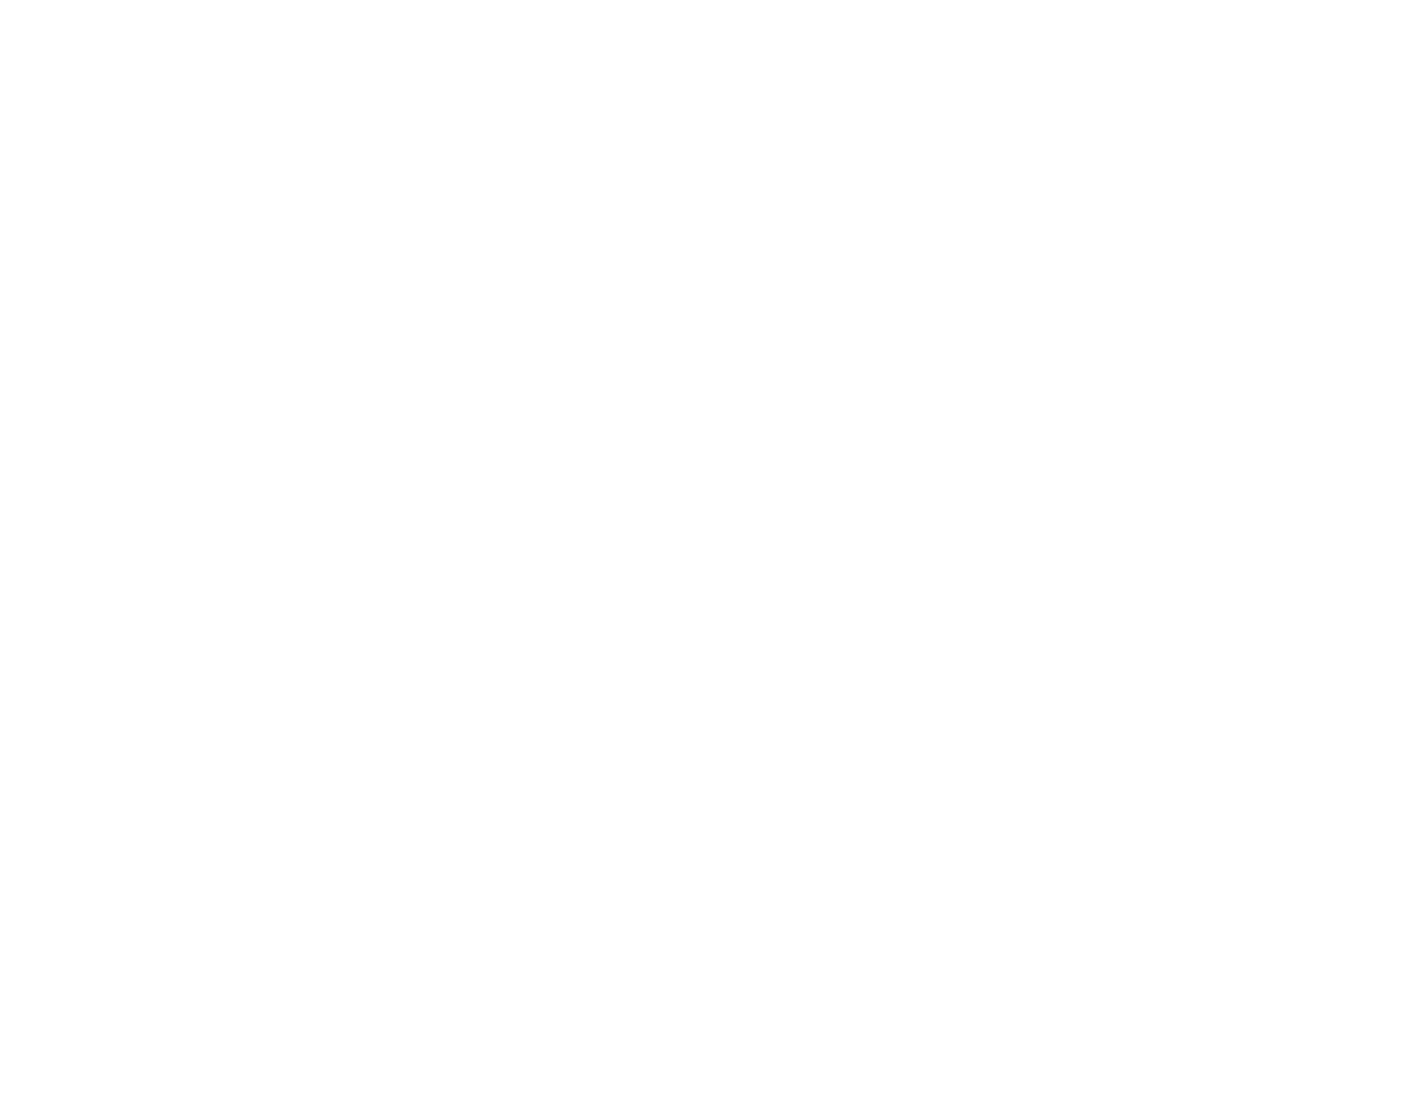

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [36]:
NaI_Cs_peaks, NaI_Cs_centroids, NaI_Cs_error = fitting_peaks(NaI_Cs_channels, NaI_Cs_counts, 10, 20, 2.5, 5, "$Cs_{137}$")

<IPython.core.display.Javascript object>


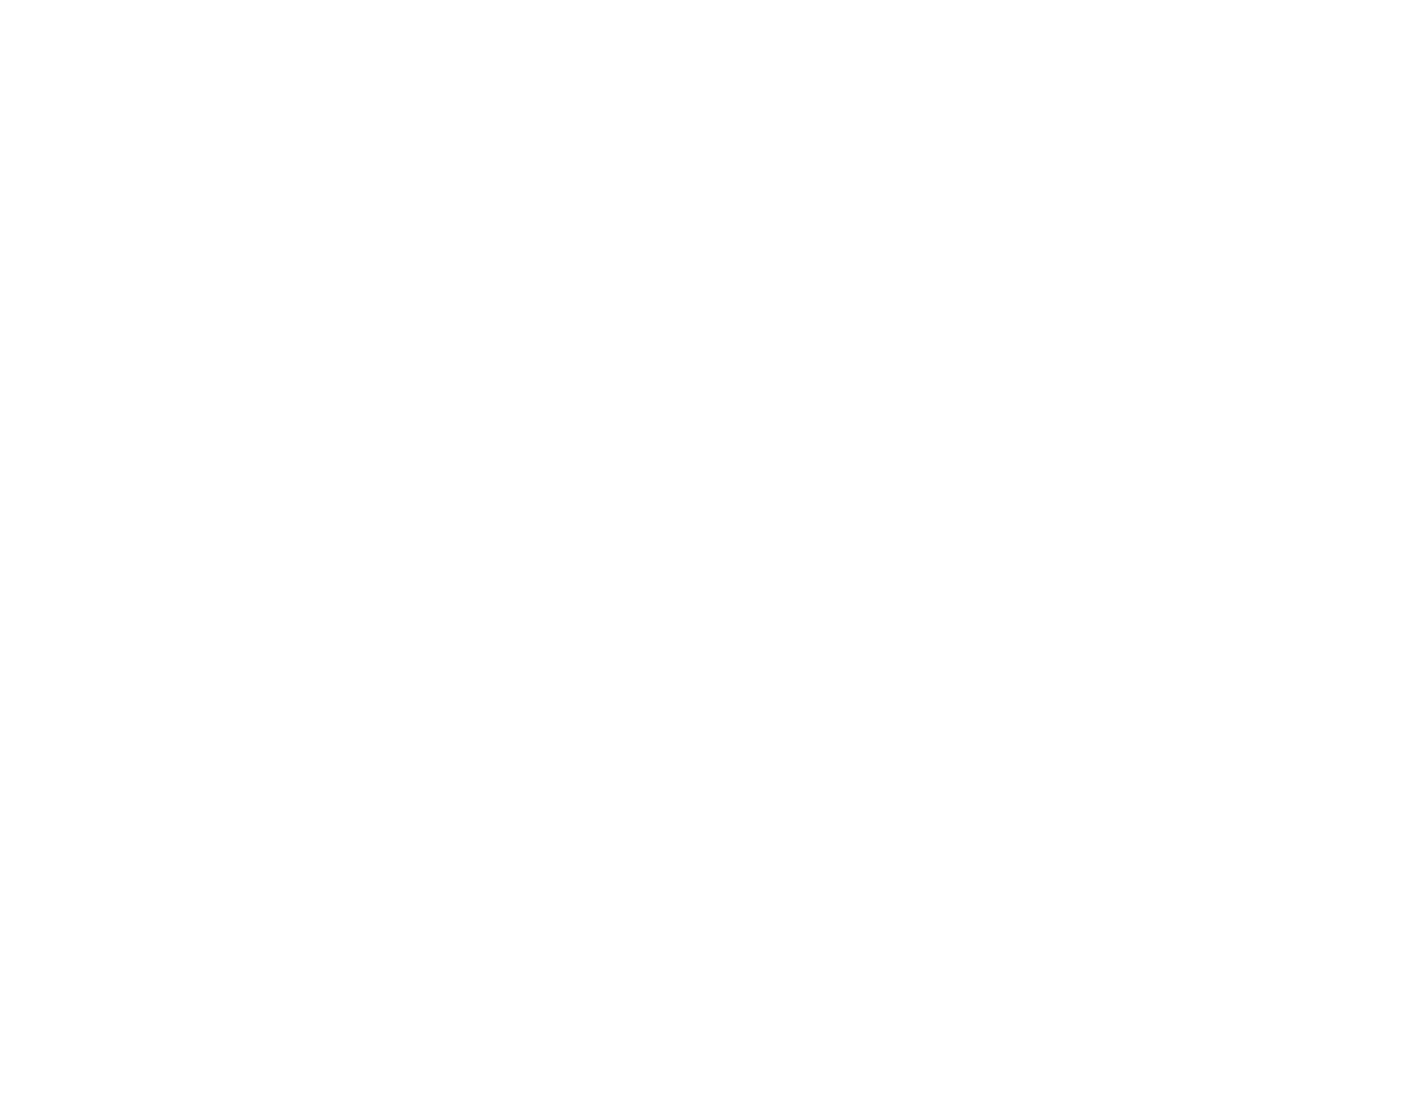

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat

In [37]:
NaI_Co_peaks, NaI_Co_centroids, NaI_Co_error = fitting_peaks(NaI_Co_channels, NaI_Co_counts, 10, 20, 0.01, 6, "$Co_{60}$")

In [38]:
NaI_dictionary = {"Barium-133":[NaI_Ba_centroids, NaI_Ba_error, Ba_energies],
                 "Americium-241":[NaI_Am_centroids, NaI_Am_error, Am_energies],
                 "Cobalt-60":[NaI_Co_centroids, NaI_Co_error, Co_energies],
                 "Caesium-137":[NaI_Cs_centroids, NaI_Cs_error, Cs_energies]}

In [39]:
NaI_Ba_channels = NaI_Ba_centroids
NaI_Am_channels = NaI_Am_centroids
NaI_Cs_channels = NaI_Cs_centroids
NaI_channels = NaI_Ba_channels[1:4] + NaI_Am_channels + NaI_Cs_channels[1:2] + NaI_Co_centroids[4:6]
NaI_energies = Ba_energies + Am_energies + Cs_energies + Co_energies

In [40]:
NaI_df = pd.DataFrame(data=NaI_dictionary)
#df.to_csv('NaI_results.csv', index=False)

In [41]:
# %load NaI_results.csv

In [42]:
def parse_mca_files(filename):
    IS_HEADER = False
    IS_DATA = False
    header_key = []
    header_value = []
    data = []

    with open(filename) as file:
        for line in file:
            line = line.strip()

            if line == "<<PMCA SPECTRUM>>":
                IS_HEADER = True
                IS_DATA = False
                continue

            elif line == "<<DATA>>":
                IS_HEADER = False
                IS_DATA = True
                continue

            elif line.startswith("<<END") or line.startswith("<<DP5 CONFIGURATION") or line.startswith("<<DPP STATUS"):
                IS_HEADER = False
                IS_DATA = False
                continue

            # handle header lines
            if IS_HEADER:
                if "-" in line:
                    header_split = line.split("-", 1)
                    header_key.append(header_split[0].strip())
                    header_value.append(header_split[1].strip())
            
            elif IS_DATA:
                try:
                    counts = int(line.strip())
                    data.append(counts)
                except ValueError:
                    # silently skip non-data lines
                    continue

    # build data dictionary
    channels = np.arange(len(data))
    counts = np.array(data)

    # create a dictionary for the headers using the lists of keys and values
    headers = {k: v for k, v in zip(header_key, header_value)}
    
    return headers, channels, counts

In [43]:
def plot_CdTe_spectra(bkg_file, file):
    headers, channels, counts = parse_mca_files(file)
    bkg_headers, bkg_channels, bkg_counts = parse_mca_files(bkg_file)
    
    time_bkg = bkg_headers["REAL_TIME"]
    bkg_exp_time = float(time_bkg)
    
    bkg_counts_per_sec = counts_per_sec(np.array(bkg_counts), bkg_exp_time)
    
    time_data = headers["REAL_TIME"]
    data_exp_time = float(time_data)
    
    counts_sec = counts_per_sec(np.array(counts), data_exp_time)
    
    counts_minus_bkg = (np.array(counts_sec) - np.array(bkg_counts_per_sec)).flatten()
    
    if "Am" in file:
        title = "$Am_{241}$"
        
    if "Co" in file:
        title = "$Co_{60}$"
        
    if "Ba" in file:
        title = "$Ba_{133}$"
        
    if "Cs" in file:
        title = "$Cs_{137}$"
    
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(channels, counts_minus_bkg, label=f"{title} Spectrum")
    ax.set_title(f"{title} Spectrum CdTe Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    plt.tight_layout()
    plt.show()
    
    return headers, channels, counts_sec, counts_minus_bkg

In [44]:
CdTe_Am_file = "CdTe_Am_direct.mca"
CdTe_Ba_file = "CdTe_Ba_direct.mca"
CdTe_Co_file = "CdTe_Co_direct.mca"
CdTe_Cs_file = "CdTe_Cs_direct.mca"
CdTe_bkg_file = "CdTe_bck_10min.mca"

<IPython.core.display.Javascript object>


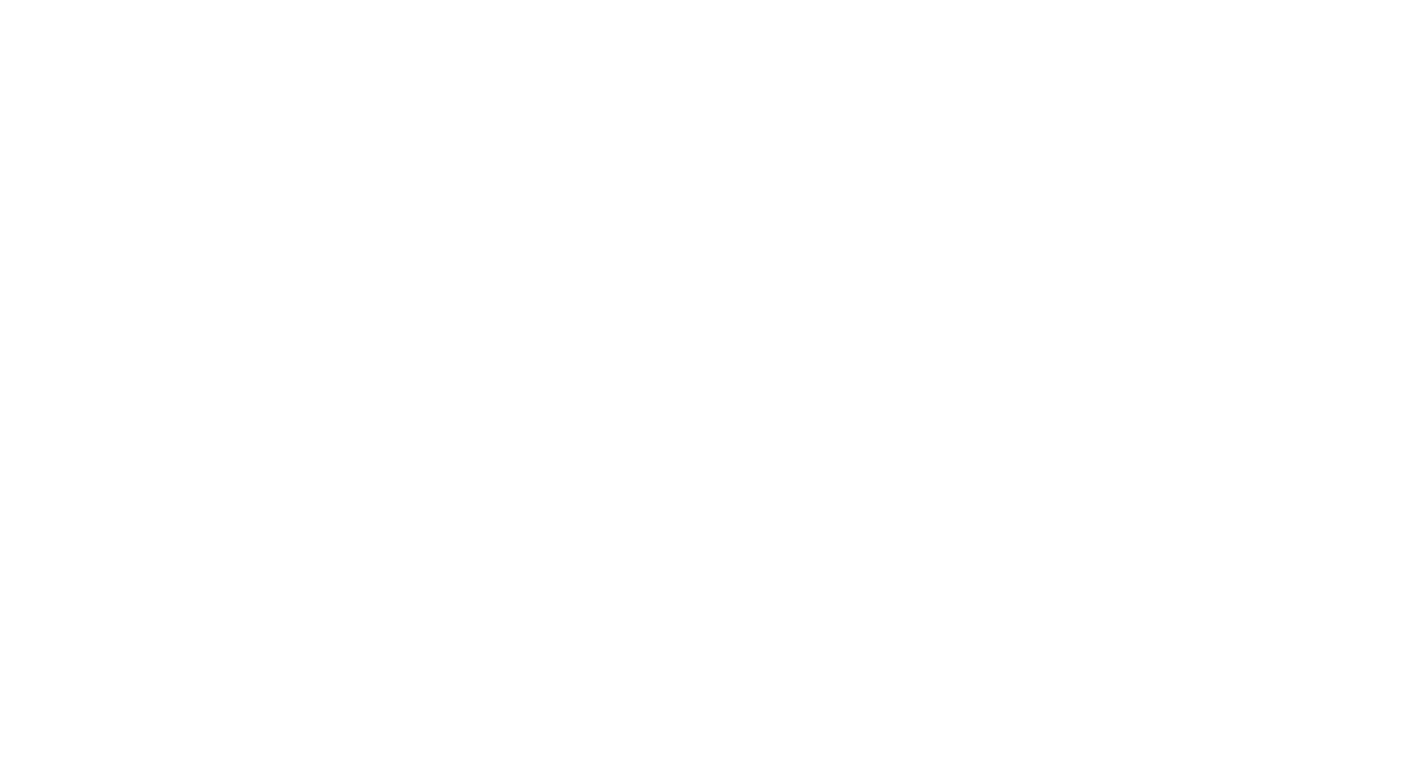

In [45]:
bkg_headers, bkg_channels, bkg_counts = parse_mca_files(CdTe_bkg_file)
    
time_bkg = bkg_headers["REAL_TIME"]
bkg_exp_time = float(time_bkg)
    
bkg_counts_per_sec = counts_per_sec(np.array(bkg_counts), bkg_exp_time)
    
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(bkg_channels, bkg_counts_per_sec, label="Background Spectrum")
ax.set_title("Background Spectrum CdTe Detector")
ax.set_xlabel("Channels")
ax.set_ylabel("Counts/sec")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


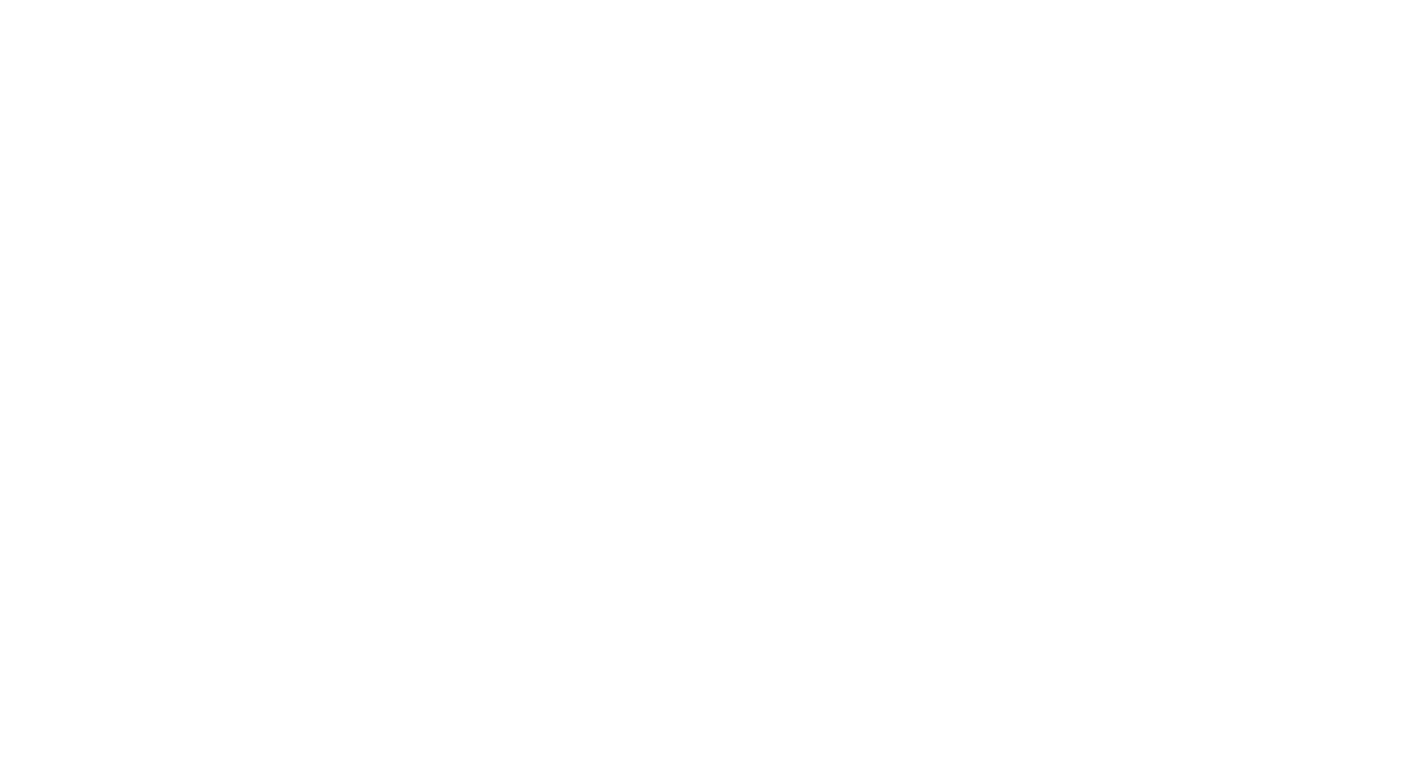

In [46]:
CdTe_Am_headers, CdTe_Am_channels, CdTe_Am_counts, CdTe_Am_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Am_file)

<IPython.core.display.Javascript object>


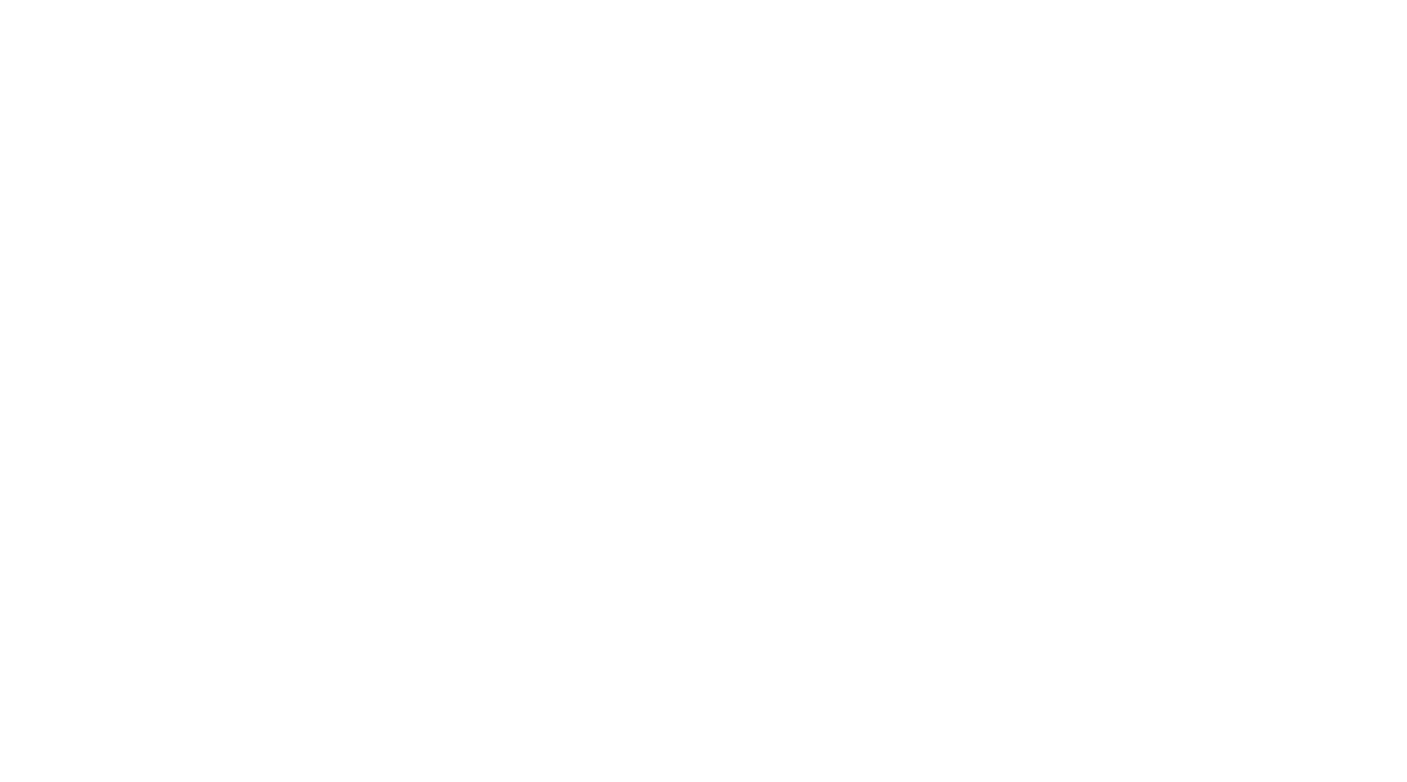

In [47]:
CdTe_Ba_headers, CdTe_Ba_channels, CdTe_Ba_counts, CdTe_Ba_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Ba_file)

<ipython-input-43-1f9e8b6be524>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(9, 5))


<IPython.core.display.Javascript object>


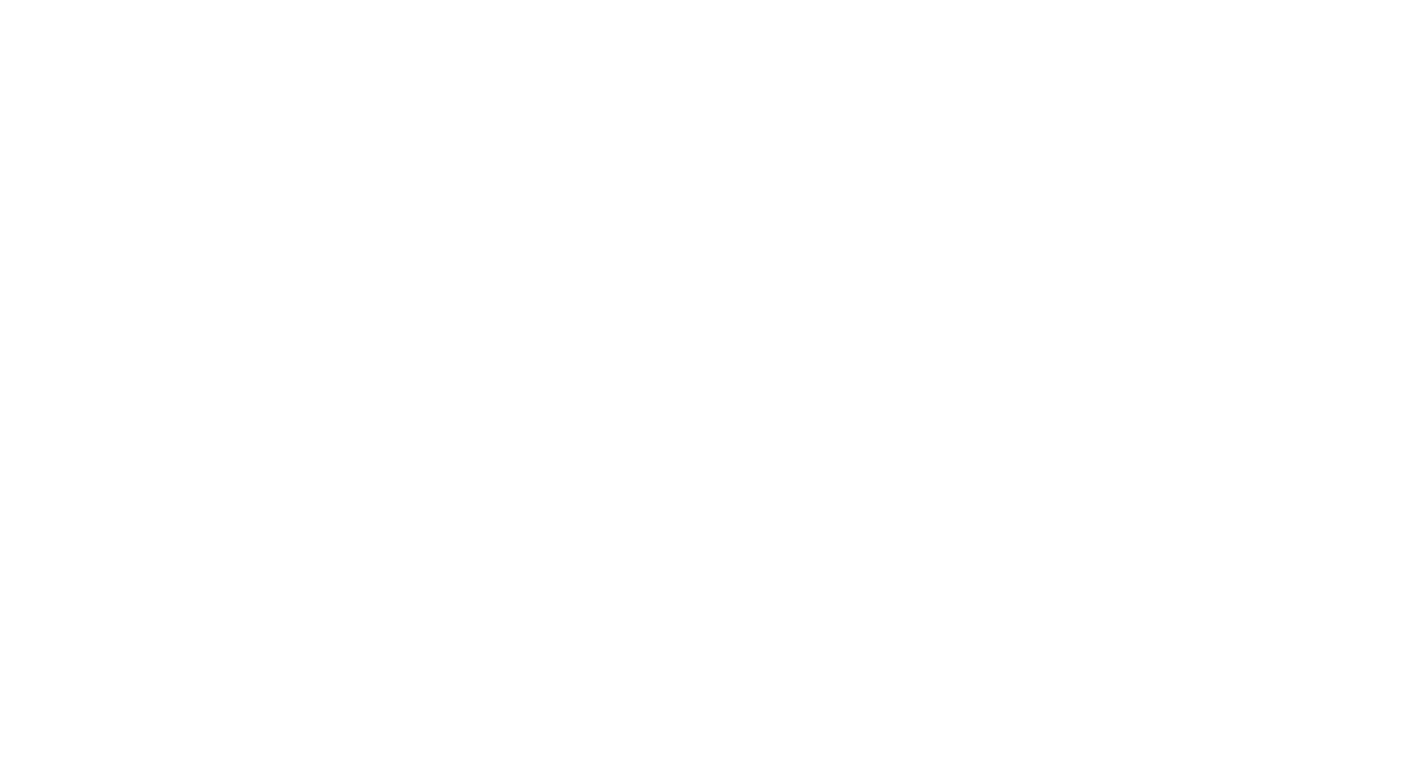

In [48]:
CdTe_Co_headers, CdTe_Co_channels, CdTe_Co_counts, CdTe_Co_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Co_file)

<IPython.core.display.Javascript object>


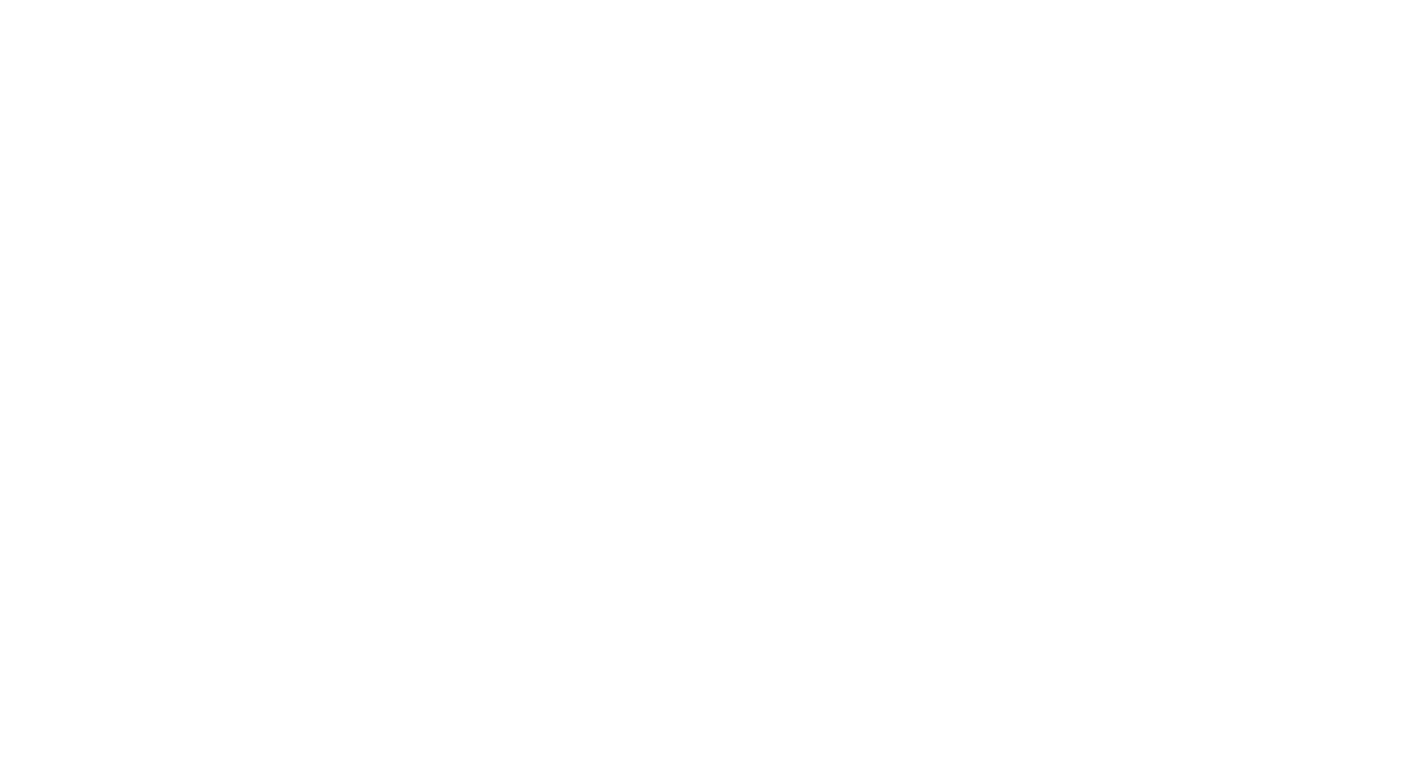

In [49]:
CdTe_Cs_headers, CdTe_Cs_channels, CdTe_Cs_counts, CdTe_Cs_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Cs_file)

In [50]:
def fitting_peaks_CdTe(channels, counts, lower, upper, height, width, title):
    # find peaks
    peaks, _ = find_peaks(counts, height=height, width=width)
    
    # loop through peaks and fit gaussian
    model = GaussianModel()
    
    gauss_peaks = []
    centroids = []
    centroid_error = []
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(channels, counts, "--")
    
    for peak in peaks:
        channel_range = np.arange((peak-lower), (peak+upper))
        
        params = model.guess(counts[channel_range], channels[channel_range])
        
        result = model.fit(counts[channel_range], x=channels[channel_range], params=params)
        
        # add result to peaks array
        gauss_peaks.append(result)
        centroids.append(result.params["center"].value)
        centroid_error.append(result.params["center"].stderr)
        
        ax.plot(channels[channel_range], result.init_fit, "--", label="initial fit peak")
        ax.plot(channels[channel_range], result.best_fit, "-", label="best fit peak")
        
    ax.set_title(f"{title} Fitted Peaks CdTe Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    ax.legend()
    plt.show()
        
    return gauss_peaks, centroids, centroid_error

<IPython.core.display.Javascript object>


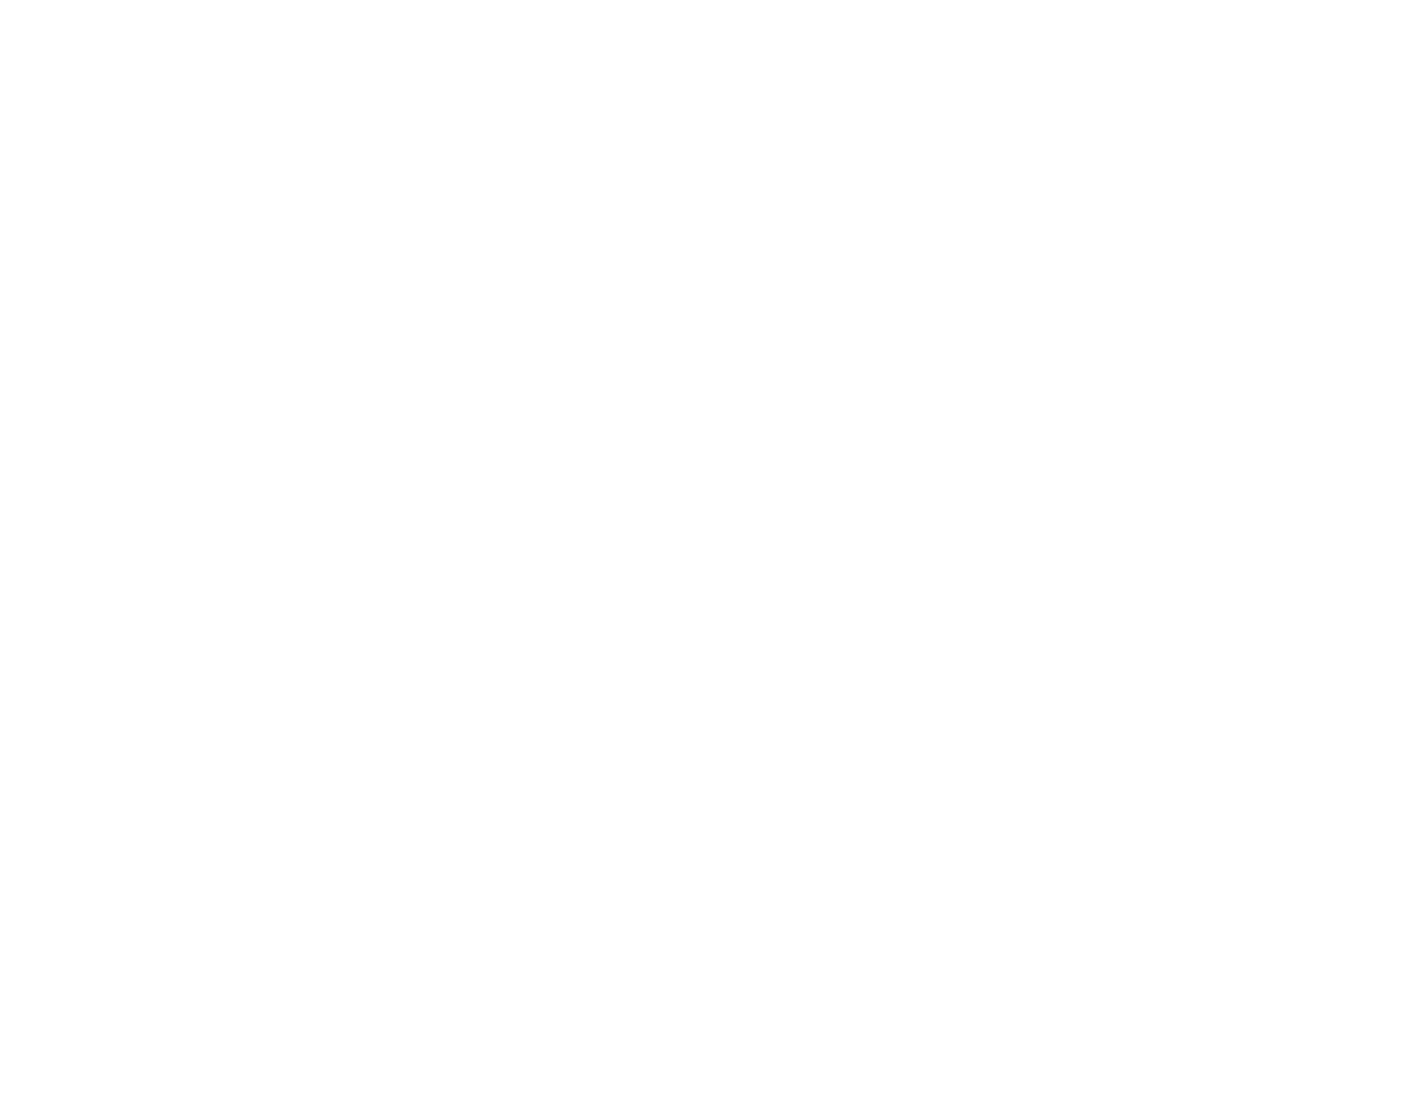

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [51]:
CdTe_Am_gauss_peaks, CdTe_Am_centroids, CdTe_Am_centroid_error = fitting_peaks_CdTe(CdTe_Am_channels, CdTe_Am_counts, 2, 2, 1.0, None, "$Am_{241}$")

<IPython.core.display.Javascript object>


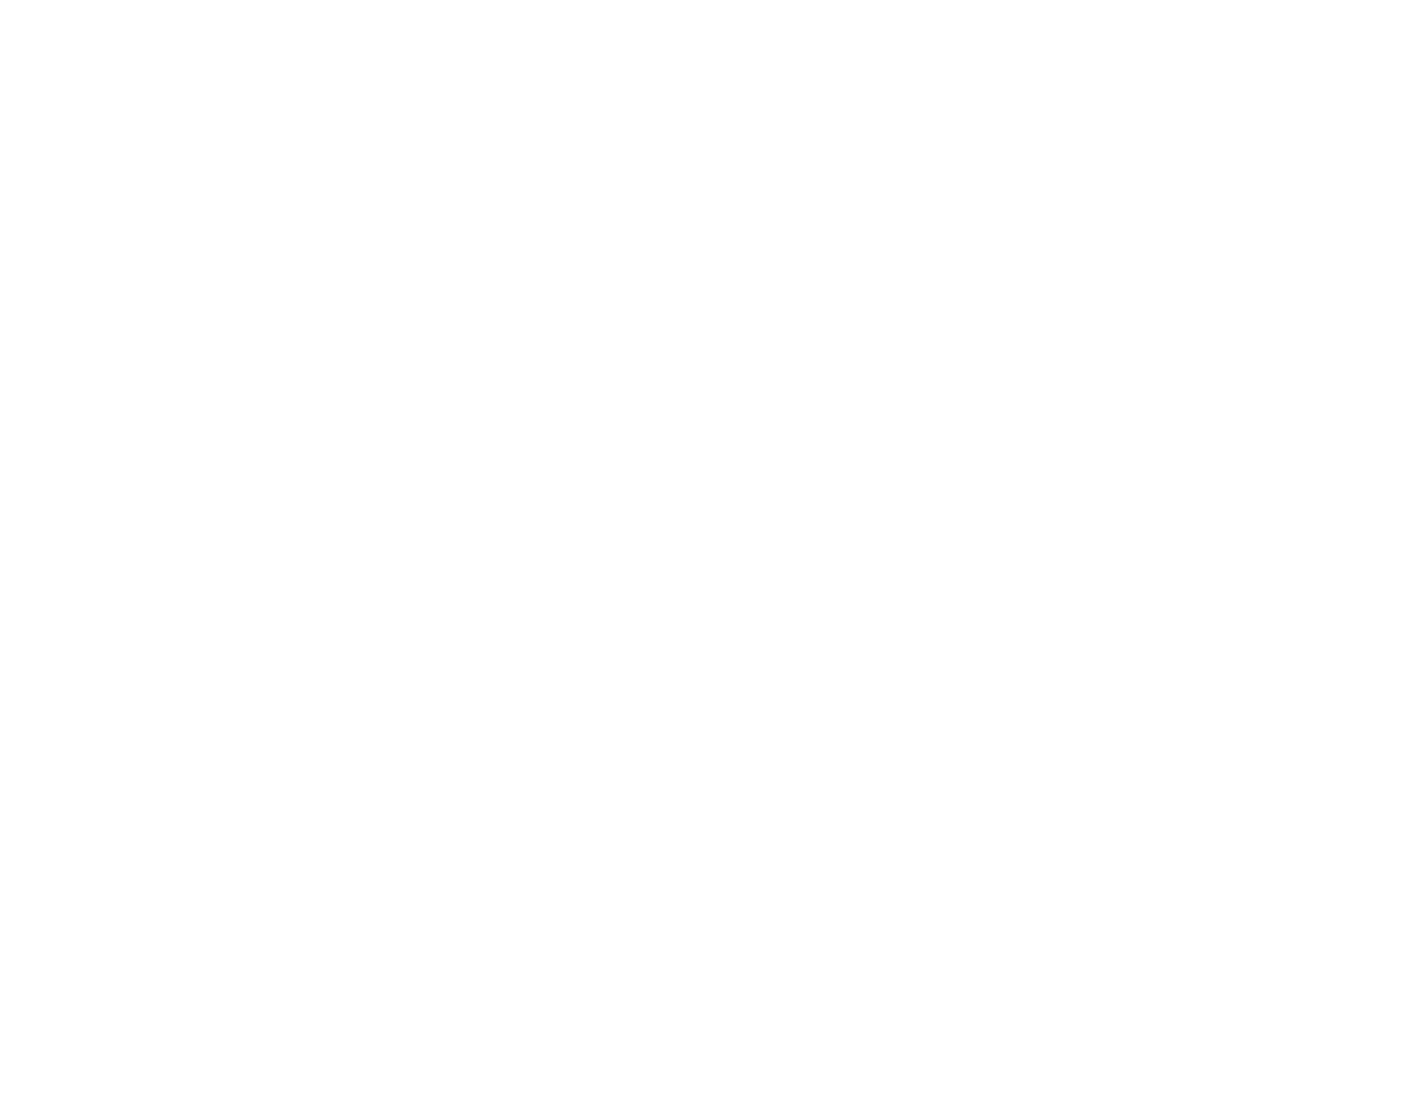

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [52]:
CdTe_Ba_gauss_peaks, CdTe_Ba_centroids, CdTe_Ba_centroid_error = fitting_peaks_CdTe(CdTe_Ba_channels, CdTe_Ba_counts, 2, 2, [0.04,0.25], None, "$Ba_{133}$")

<IPython.core.display.Javascript object>


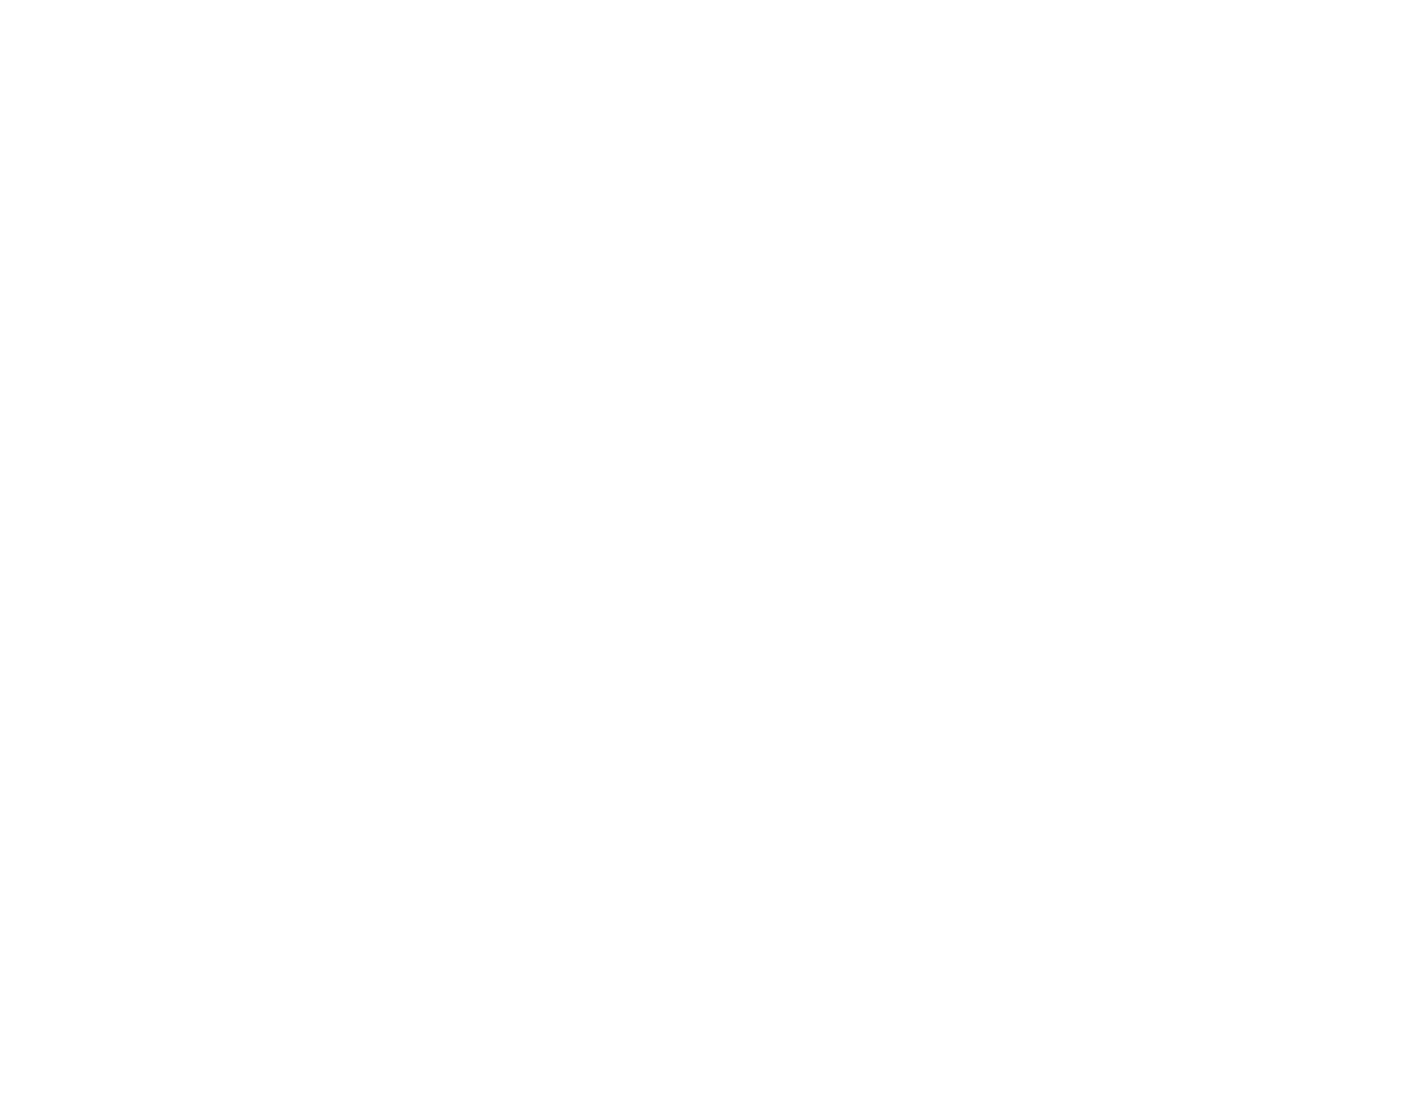

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [53]:
CdTe_Cs_gauss_peaks, CdTe_Cs_centroids, CdTe_Cs_centroid_error = fitting_peaks_CdTe(CdTe_Cs_channels, CdTe_Cs_counts, 2, 2, [0.015,0.25], None, "$Cs_{137}$")

In [54]:
CdTe_dictionary = {"Barium-133":[CdTe_Ba_centroids, CdTe_Ba_centroid_error, Ba_energies],
                 "Americium-241":[CdTe_Am_centroids, CdTe_Am_centroid_error, Am_energies],
                 "Caesium-137":[CdTe_Cs_centroids, CdTe_Cs_centroid_error, Cs_energies]}

In [55]:
CdTe_df = pd.DataFrame(data=CdTe_dictionary)
#df.to_csv('CdTe_results.csv', index=False)

In [56]:
CdTe_Cs_energy = [31.85]

In [57]:
CdTe_channels = CdTe_Ba_centroids + CdTe_Am_centroids + CdTe_Cs_centroids[1:2]
CdTe_energies = Ba_energies + Am_energies + CdTe_Cs_energy
CdTe_channel_errors = CdTe_Ba_centroid_error + CdTe_Am_centroid_error + CdTe_Cs_centroid_error[1:2]

In [58]:
BGO_channel_errors = BGO_Ba_error + BGO_Am_error + BGO_Cs_error[2:3] + BGO_Co_error[2:4]

In [59]:
NaI_channel_errors = NaI_Ba_error[1:4] + NaI_Am_error + NaI_Cs_error[1:2] + NaI_Co_error[4:6]

In [60]:
from scipy import odr

def linear_fit_odr(energies, channels, channel_err, name):
    """
    Performs a linear calibration (Energy vs Channel) using scipy.odr,
    which properly accounts for uncertainties in the x-values (channels).

    Model: E = m*x + c

    Parameters
    ----------
    energies : array-like
        Known energies for calibration peaks (y-values)
    channels : array-like
        Measured centroid channel numbers (x-values)
    channel_err : array-like
        1σ uncertainties of the centroid channel numbers
    name : str
        Name for plot labeling

    Returns
    -------
    output : scipy.odr.Output
        ODR fit result object
    """
    # --- Convert inputs to numpy arrays ---
    energies = np.asarray(energies, dtype=float)
    channels = np.asarray(channels, dtype=float)
    channel_err = np.asarray(channel_err, dtype=float)

    # --- Define linear model function ---
    def linear_func(B, x):
        return B[0] * x + B[1]   # B[0] = slope, B[1] = intercept

    # --- Create Model and Data for ODR ---
    model = odr.Model(linear_func)
    data = odr.RealData(channels, energies, sx=channel_err, sy=None)

    # --- Set up ODR with initial guesses ---
    beta0 = [1.0, 0.0]  # initial guess for slope, intercept
    odr_instance = odr.ODR(data, model, beta0=beta0)

    # --- Run the fit ---
    output = odr_instance.run()

    # --- Extract fit results ---
    slope, intercept = output.beta
    slope_err, intercept_err = output.sd_beta

    # --- Generate fitted line for plotting ---
    xfit = np.linspace(min(channels)*0.95, max(channels)*1.05, 300)
    yfit = linear_func(output.beta, xfit)

    # --- Plot results ---
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.errorbar(channels, energies, xerr=channel_err, fmt='o', capsize=3,
                label='Data with x-errors')
    ax.plot(xfit, yfit, 'r-', label='ODR linear fit')
    ax.set_title(f"{name} Energies vs Channels (ODR Fit)")
    ax.set_xlabel(f"{name} Channels")
    ax.set_ylabel(f"{name} Energies (keV)")
    ax.legend()
    plt.show()

    # --- Print results ---
    print(f"\nLinear ODR Fit Results for {name}")
    print(f"--------------------------------")
    print(f"Slope      = {slope:.6f} ± {slope_err:.6f}")
    print(f"Intercept  = {intercept:.6f} ± {intercept_err:.6f}")
    print(f"Residual Variance = {output.res_var:.6f}")

    return output

<IPython.core.display.Javascript object>


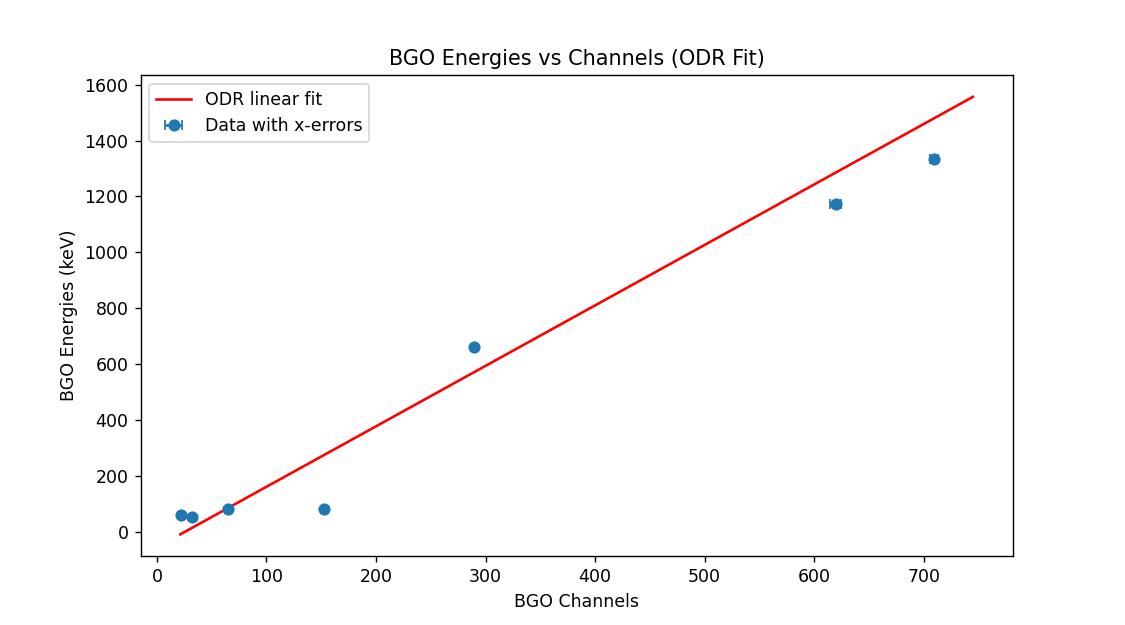


Linear ODR Fit Results for BGO
--------------------------------
Slope      = 2.164658 ± 0.440331
Intercept  = -56.122075 ± 75.434067
Residual Variance = 9697.446583


In [69]:
BGO_odr_output = linear_fit_odr(BGO_energies, BGO_channels, BGO_channel_errors, "BGO")

<IPython.core.display.Javascript object>


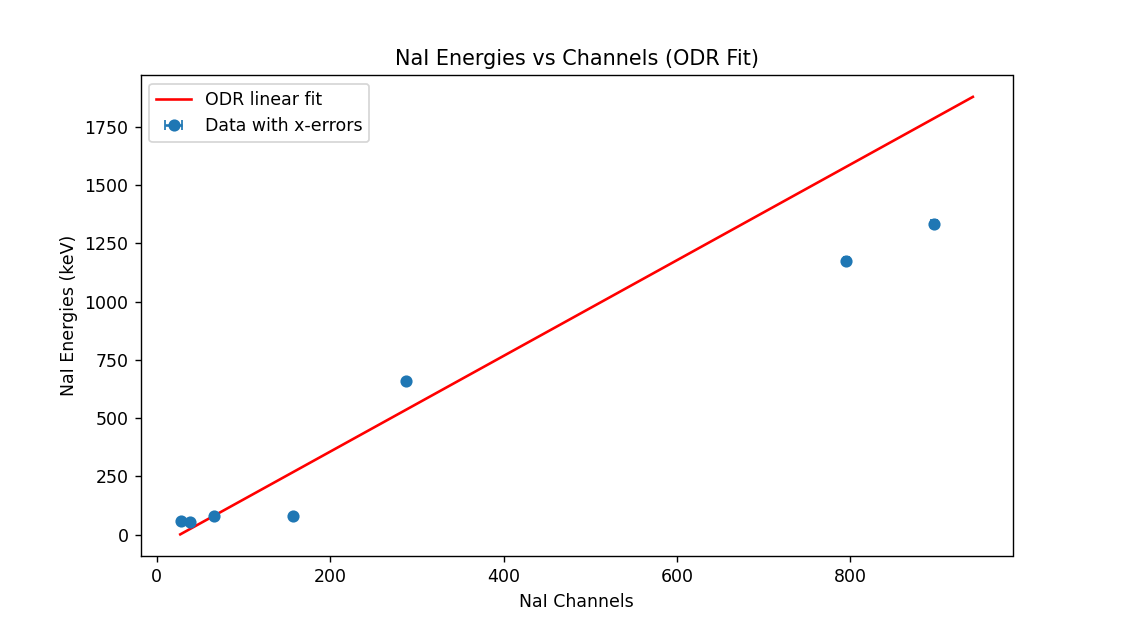


Linear ODR Fit Results for NaI
--------------------------------
Slope      = 2.053951 ± 0.474183
Intercept  = -54.199238 ± 86.249911
Residual Variance = 11352.607277


In [70]:
NaI_linear_odr_result = linear_fit_odr(NaI_energies, NaI_channels, NaI_channel_errors, "NaI")

<IPython.core.display.Javascript object>


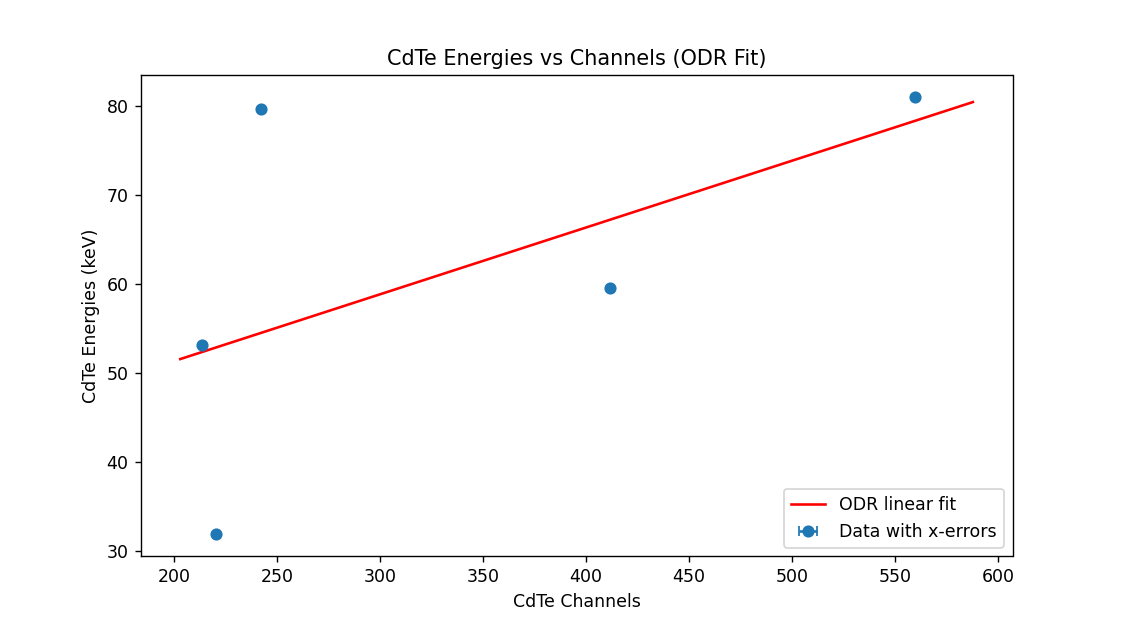


Linear ODR Fit Results for CdTe
--------------------------------
Slope      = 0.075018 ± 0.063973
Intercept  = 36.310636 ± 22.807380
Residual Variance = 379.303837


In [71]:
CdTe_linear_odr_result = linear_fit_odr(CdTe_energies, CdTe_channels, CdTe_channel_errors, "CdTe")

In [64]:
def quadratic_fit_odr(energies, channels, channel_err, name):
    """
    Performs a quadratic calibration (Energy vs Channel) using scipy.odr,
    which properly accounts for uncertainties in x (channels).

    Model: E = a*x^2 + b*x + c

    Parameters
    ----------
    energies : array-like
        Known energies for calibration peaks (y-values)
    channels : array-like
        Measured centroid channel numbers (x-values)
    channel_err : array-like
        1σ uncertainties of the centroid channel numbers
    name : str
        Name for plot labeling

    Returns
    -------
    output : scipy.odr.Output
        ODR fit result object with parameters and uncertainties
    """
    # --- Convert to numpy arrays ---
    energies = np.asarray(energies, dtype=float)
    channels = np.asarray(channels, dtype=float)
    channel_err = np.asarray(channel_err, dtype=float)

    # --- Define quadratic model ---
    def quad_func(B, x):
        return B[0]*x**2 + B[1]*x + B[2]  # B = [a, b, c]

    # --- Create ODR Model and RealData objects ---
    model = odr.Model(quad_func)
    data = odr.RealData(channels, energies, sx=channel_err, sy=None)

    # --- Initial parameter guesses (rough but works fine) ---
    beta0 = [0.0, 1.0, 0.0]  # a, b, c

    # --- Run the ODR fit ---
    odr_instance = odr.ODR(data, model, beta0=beta0)
    output = odr_instance.run()

    # --- Extract results ---
    a, b, c = output.beta
    sa, sb, sc = output.sd_beta

    # --- Generate fitted curve for plotting ---
    xfit = np.linspace(min(channels)*0.9, max(channels)*1.1, 300)
    yfit = quad_func(output.beta, xfit)

    # --- Plot results ---
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.errorbar(channels, energies, xerr=channel_err, fmt='o', capsize=3,
                label='Data with x-errors')
    ax.plot(xfit, yfit, 'r-', label='Quadratic ODR fit')
    ax.set_title(f"{name} Energies vs Channels (Quadratic ODR)")
    ax.set_xlabel(f"{name} Channels")
    ax.set_ylabel(f"{name} Energies (keV)")
    ax.legend()
    plt.show()

    # --- Print results ---
    print(f"\nQuadratic ODR Fit Results for {name}")
    print(f"-------------------------------------")
    print(f"a (x² term) = {a:.6e} ± {sa:.6e}")
    print(f"b (x term)  = {b:.6e} ± {sb:.6e}")
    print(f"c (offset)  = {c:.6e} ± {sc:.6e}")
    print(f"Residual Variance = {output.res_var:.6f}")

    return output

<IPython.core.display.Javascript object>


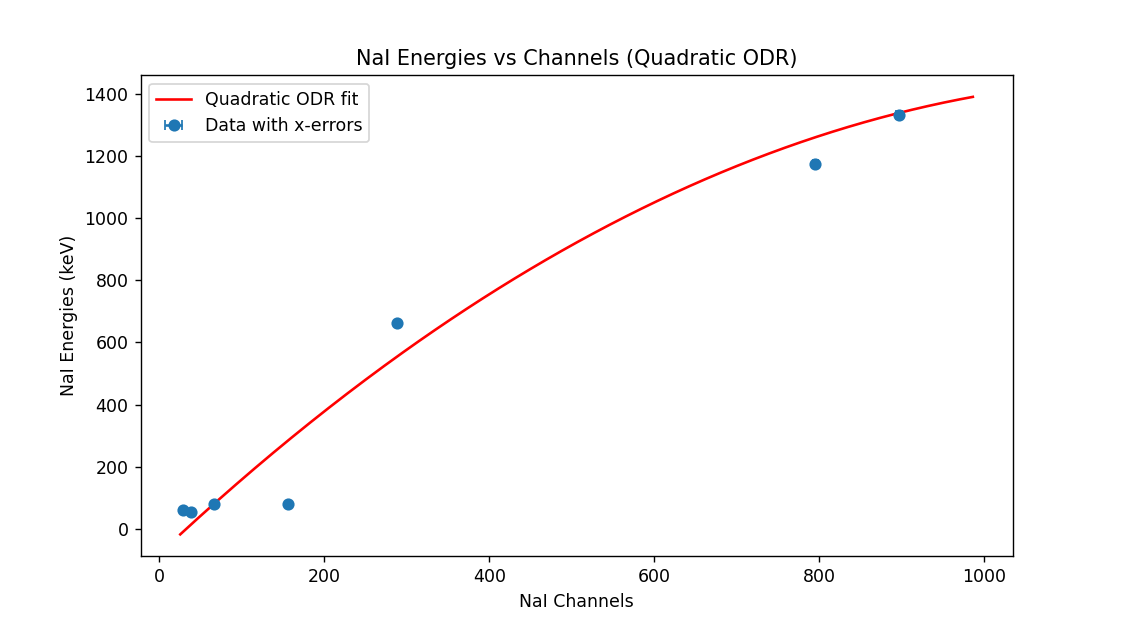


Quadratic ODR Fit Results for NaI
-------------------------------------
a (x² term) = -1.020462e-03 ± 1.042348e-03
b (x term)  = 2.498776e+00 ± 8.836282e-01
c (offset)  = -8.132029e+01 ± 1.104344e+02
Residual Variance = 13400.992200


In [72]:
NaI_quad_odr_result = quadratic_fit_odr(NaI_energies, NaI_channels, NaI_channel_errors, "NaI")

<IPython.core.display.Javascript object>


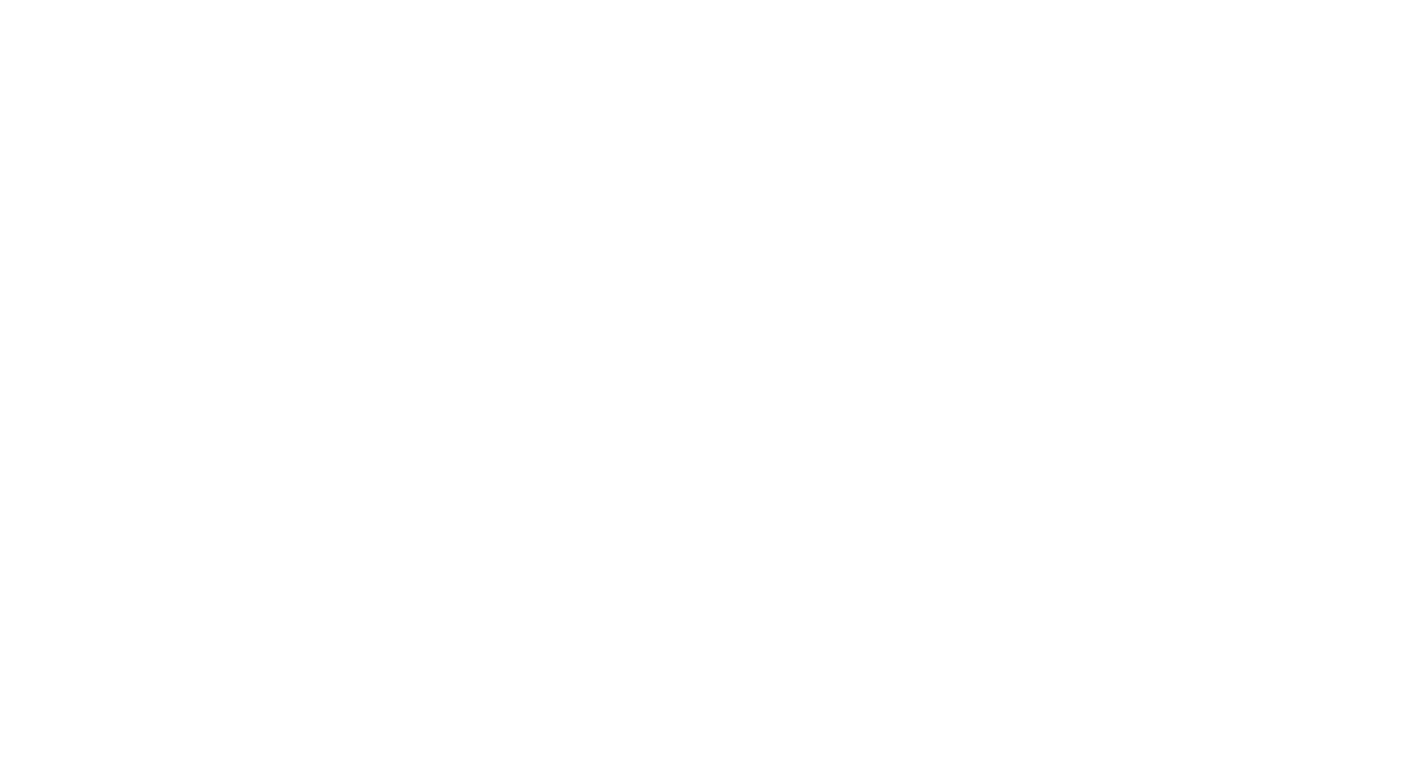


Quadratic ODR Fit Results for BGO
-------------------------------------
a (x² term) = 1.426947e-02 ± 4.173271e-03
b (x term)  = -2.315708e+00 ± 1.303282e+00
c (offset)  = 1.211149e+02 ± 6.247486e+01
Residual Variance = 3537.327738


In [66]:
BGO_quad_odr_result = quadratic_fit_odr(BGO_energies, BGO_channels, BGO_channel_errors, "BGO")

In scipy.odr, the residual variance (output.res_var) is a measure of the average squared normalized deviation between your fitted model and your data points — it tells you how well your model matches the data, after accounting for the measurement uncertainties you provided.

Your fit explains the data poorly compared to how small your reported uncertainties are.

The uncertainties are too small

This is the most common cause in your situation.

You’re using centroid errors from Gaussian fits as channel_err, and those are usually tiny (fractions of a channel, like 0.05).
However:

They represent statistical fit precision, not total calibration uncertainty.

Real uncertainties (including systematic effects, electronics, peak shape, etc.) are much larger — often a few channels in real spectra.

So ODR thinks your x-errors are almost zero, forcing the fit to “explain” deviations that are actually just real variation in the system — hence res_var >> 1.

In [67]:
## Energy Resolution
# Resolution at some peak  = FWHM / peak's energy
# supposed to make it a function of energy? ?? maybe plot resolution vs the energy

# Calculate Resolution
#Am241_BGO_Res = (Am_results[0].params['fwhm'].value)/Am_energies[0]

In [68]:
BGO_Am_result.params["fwhm"].value

NameError: name 'BGO_Am_result' is not defined